# Análisis Resultados


## Funciones

Funciones para cargar los resultados y visualizarlos

In [3]:
# cargar fichero resultados
import pandas as pd
import numpy as np

def load_result(path_file:str):
    df= pd.read_csv(path_file, header=None, usecols=[0] + list(np.arange(3, 30)),  index_col=0)
    df.columns=[
    "mol_pred_loaded",
    "mol_true_loaded",
    "mol_cond_loaded",
    "sanitization",
    "inchi_convertible",
    "all_atoms_connected",
    "molecular_formula",
    "molecular_bonds",
    "double_bond_stereochemistry",
    "tetrahedral_chirality",
    "bond_lengths",
    "bond_angles",
    "internal_steric_clash",
    "aromatic_ring_flatness",
    "non_aromatic_ring_non_flatness",
    "double_bond_flatness",
    "internal_energy",
    "protein_ligand_maximum_distance",
    "minimum_distance_to_protein",
    "minimum_distance_to_organic_cofactors",
    "minimum_distance_to_inorganic_cofactors",
    "minimum_distance_to_waters",
    "volume_overlap_with_protein",
    "volume_overlap_with_organic_cofactors",
    "volume_overlap_with_inorganic_cofactors",
    "volume_overlap_with_waters",
    "rmsd_leq_2A"
]
    return df


In [4]:
# número de test que pasa cada complejo proteina-ligando
def test_per_complex(df):
    return df.sum(axis=1)


In [5]:
# complejos que pasan todos los test
def all_test(df):
    return df.all(axis=1)

In [6]:
# Visualizaciones

import matplotlib.pyplot as plt

def plot_test_test_per_complex(data, title):

    normalized_data =test_per_complex(data)/27
    colors = ['red' if val >= 1 else 'blue' for val in normalized_data]

    ax = normalized_data.plot(kind="bar", figsize=(20, 5), color=colors)
    plt.xlabel("Test")
    plt.ylabel("Número de complejos que pasan el test")
    plt.title(title)
    plt.show()


import seaborn as sns

def plot_heat_map(data):
    plt.figure(figsize=(20, 18))
    sns.heatmap(data.astype(int), cmap="coolwarm", cbar=True)
    plt.xlabel("Tests")
    plt.ylabel("Complejos proteína-ligando")
    plt.show()


In [7]:
# visualición 3d de los complejos proteína con múltiples ligandos superpuestos en py3Dmol.
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem

def visualization(protein_path, ligand_list, colors_list, width=500, height=500):
    with open(protein_path) as ifile:
        protein = ifile.read()

    # creación del visor visor
    viewer = py3Dmol.view(width=width, height=height)
    viewer.addModel(protein, 'pdb')

    # añadir los ligandos
    mol_objects = []
    for path in ligand_list:
        mol = Chem.SDMolSupplier(path)[0]
        mol_objects.append(mol)
        viewer.addModel(Chem.MolToMolBlock(mol), 'sdf')

    # Establecer estilos
    viewer.setStyle({'model': 0}, {'cartoon': {'color': 'gray'}})

    for i, mol in enumerate(mol_objects):
        color = colors_list[i]
        viewer.setStyle({'model': i + 1}, {'stick': {'color': color}})

    # Mostrar
    viewer.zoomTo()
    viewer.show()


In [ ]:
# Upset plot para comporar los resultados
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators

def true_rows(df):
    """Devuelve los índices de las filas donde todos los valores son True."""
    return set(df.index[df.all(axis=1)])

def generar_upset_plot(df_dict, figsize=(12, 6)):


    sets = {name: true_rows(df) for name, df in df_dict.items()}

    all_indices = set.union(*sets.values())

    binary_data = {
        idx: [idx in sets[name] for name in df_dict.keys()]
        for idx in all_indices
    }

    binary_df = pd.DataFrame.from_dict(
        binary_data, orient="index", columns=list(df_dict.keys())
    )

    upset_data = from_indicators(binary_df.columns, binary_df)

    # Graficar
    plt.figure(figsize=figsize)
    UpSet(upset_data, show_counts=True).plot()
    plt.show()

    return binary_df


In [36]:
# Diagrama de Venn
from venn import venn
def ven_diagramm(df_dict, figsize=(12, 6) ):
    sets = {name: true_rows(df) for name, df in df_dict.items()}
# Graficar Venn
    plt.figure(figsize=(10, 10))
    venn(sets)
    plt.show()

In [ ]:
#Diagrama de Barras con los porcentajes de ligandos resultantes válidos

def compare_tool_diagram(sets_dict, total_complejos, titulo="Comparativa entre herramientas (PB-Valid vs RMSD ≤ 2Å)"):
    
    proporciones_pass_all = {}
    proporciones_rmsd = {}

    for nombre, df in sets_dict.items():
        proporciones_pass_all[nombre] = df.all(axis=1).sum() / total_complejos
        proporciones_rmsd[nombre] = df['rmsd_leq_2A'].sum() / total_complejos

    proporciones_df = pd.DataFrame({
        "PB-Valid": proporciones_pass_all,
        "RMSD ≤ 2Å": proporciones_rmsd
    })

    ax = proporciones_df.plot(kind="bar", figsize=(12,6), color=["skyblue", "salmon"], width=0.8)

    plt.ylabel(f"Proporción sobre {total_complejos} complejos")
    plt.title(titulo)
    plt.ylim(0, 1)
    plt.grid(axis='y')

    for container in ax.containers:
        ax.bar_label(container, labels=[f"{v*100:.1f}%" for v in container.datavalues], label_type='edge', fontsize=9)

    plt.xticks(rotation=0)
    plt.legend(title="Métrica")
    plt.tight_layout()

  
    plt.show()

In [45]:
def filter(df):
    """Filtrar el DataFrame para incluir solo los complejos de la lista"""
    with open("data_sets/posebusters_benchmark_set/pb.txt", "r") as f:
        protein = [x.strip() for x in f.read().split(",")]

    protein=[x.replace(' ', '_') for x in protein]
    return df.loc[df.index.intersection(protein)]

## Astex diverse set

Para el conjunto de datos Astex Diverse Set se presentan los resultados obtenidos con las diferentes herramientas, primero utilizando el ligando cristalizado y luego utilizando el ligando con la configuración inicial.

### Resultados DiffDock

#### Ligand

In [9]:
diffdock_astex=load_result("results/results_astex_diffdock/evaluation_diffdock.csv")

In [10]:
test_per_complex(diffdock_astex)

0
1G9V_RQ3    18
1GKC_NFH    25
1GM8_SOX    25
1GPK_HUP    26
1HNN_SKF    26
            ..
1YWR_LI9    27
1Z95_198    27
2BM2_PM2    26
2BR1_PFP    27
2BSM_BSM    27
Length: 85, dtype: int64

In [11]:
all_test(diffdock_astex)

0
1G9V_RQ3    False
1GKC_NFH    False
1GM8_SOX    False
1GPK_HUP    False
1HNN_SKF    False
            ...  
1YWR_LI9     True
1Z95_198     True
2BM2_PM2    False
2BR1_PFP     True
2BSM_BSM     True
Length: 85, dtype: bool

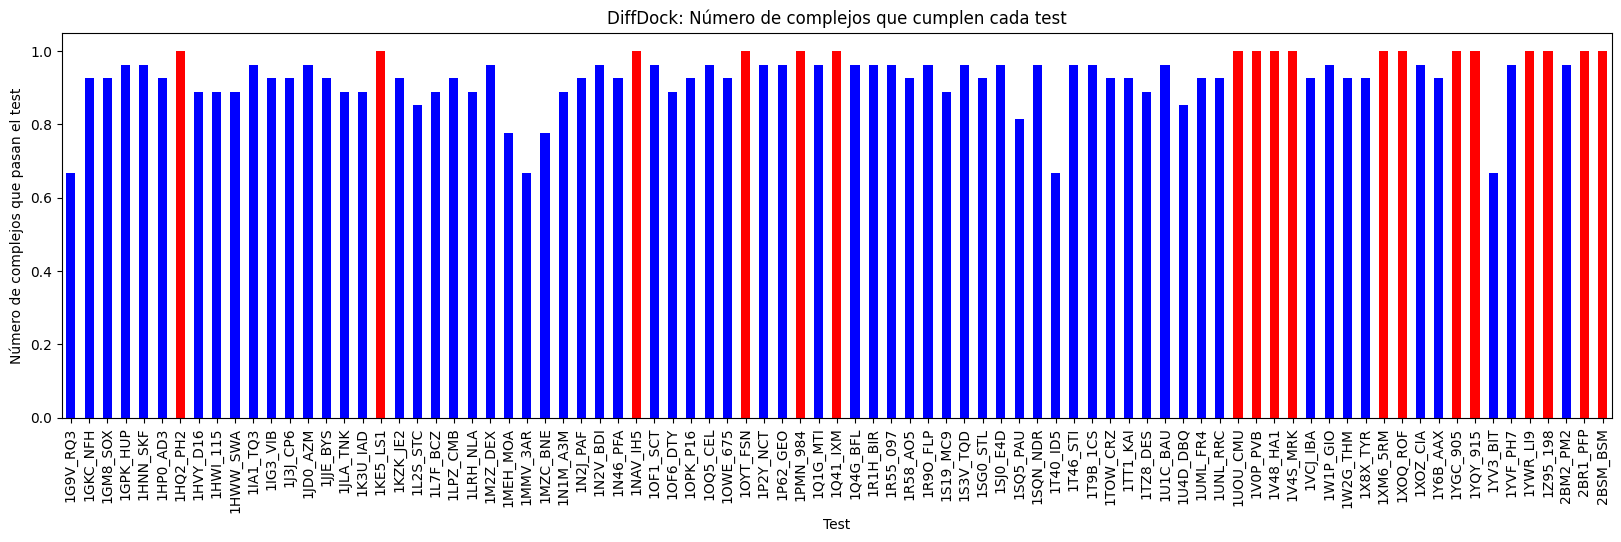

In [12]:
plot_test_test_per_complex(diffdock_astex, "DiffDock: Número de complejos que cumplen cada test")

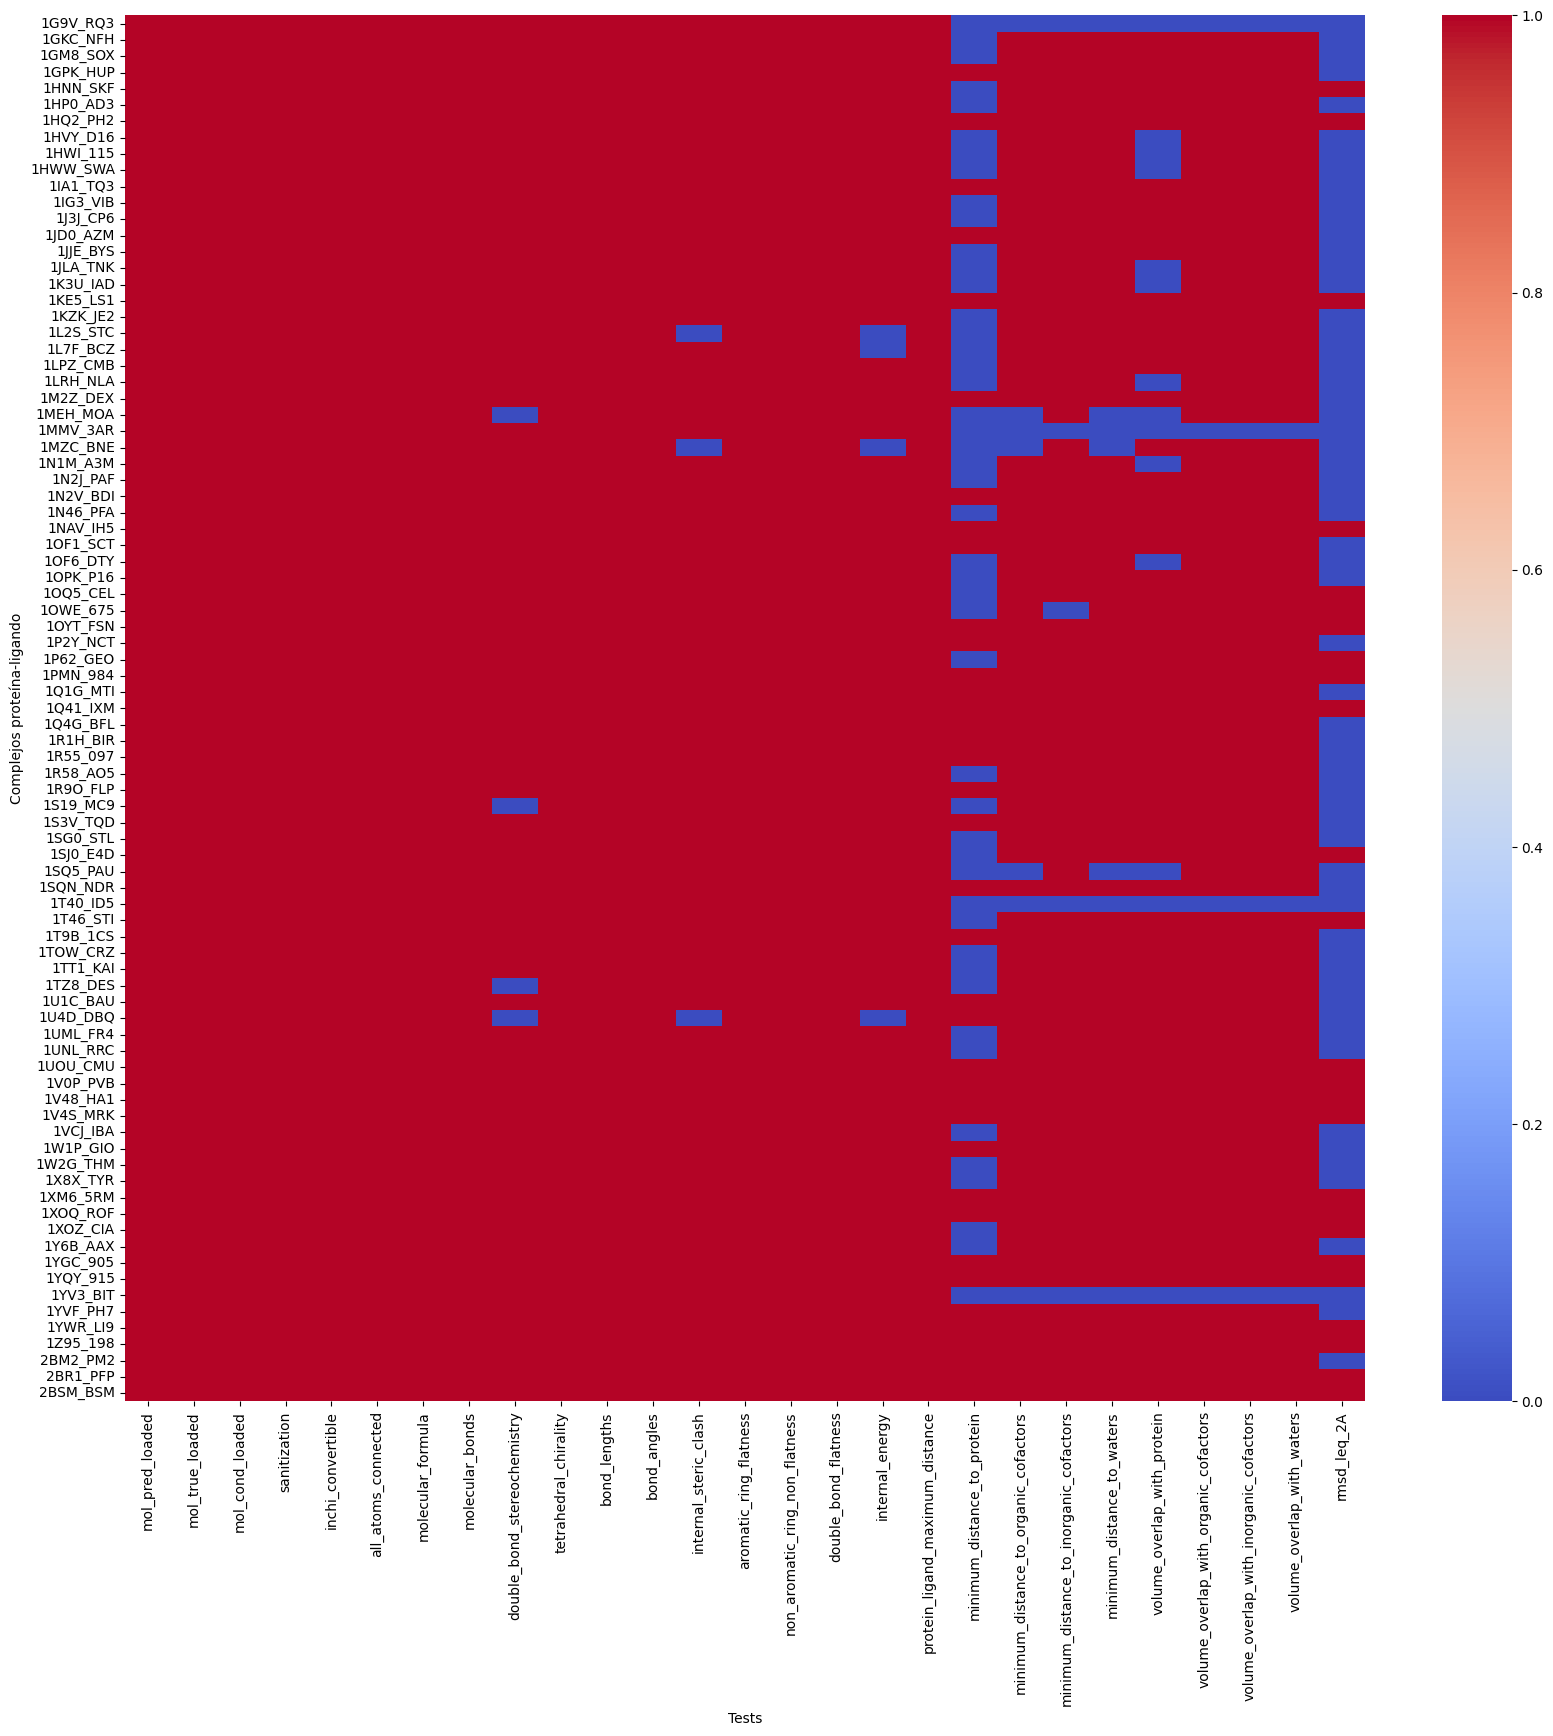

In [13]:
plot_heat_map(diffdock_astex)

#### Start Config

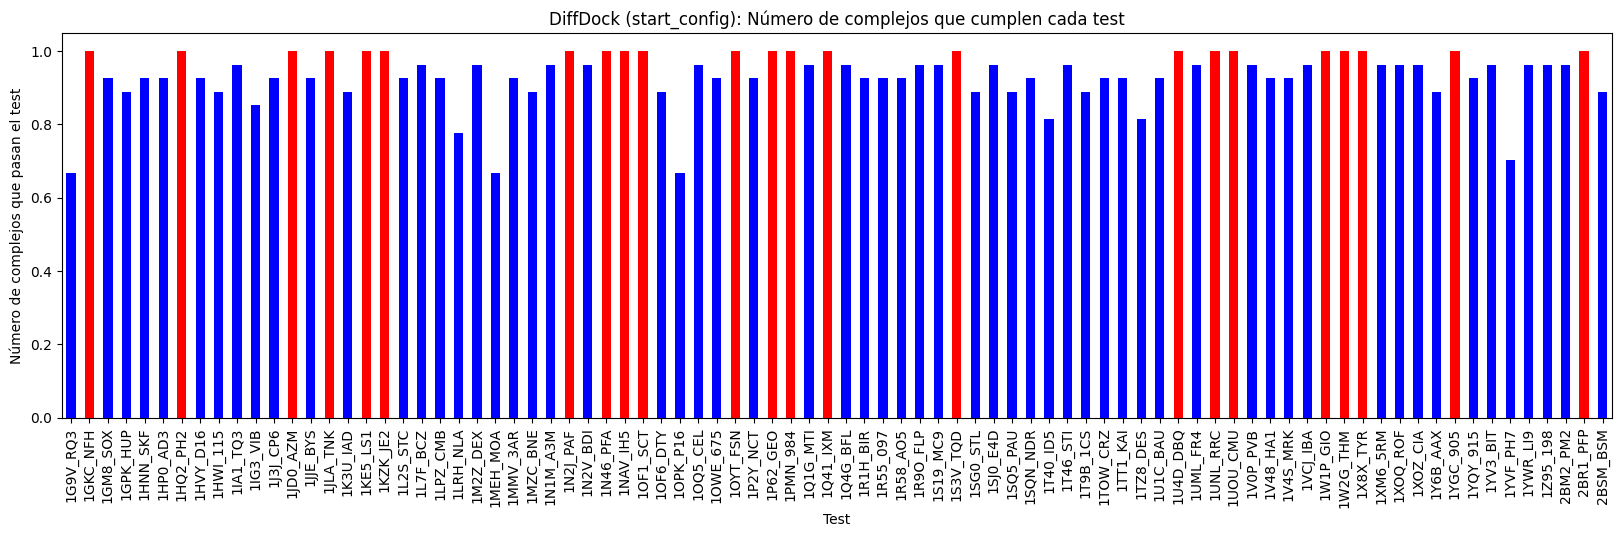

In [14]:
diffdock_astex_start=load_result("results/results_astex_start_diffdock/evaluation.csv")
plot_test_test_per_complex(diffdock_astex_start, "DiffDock (start_config): Número de complejos que cumplen cada test")

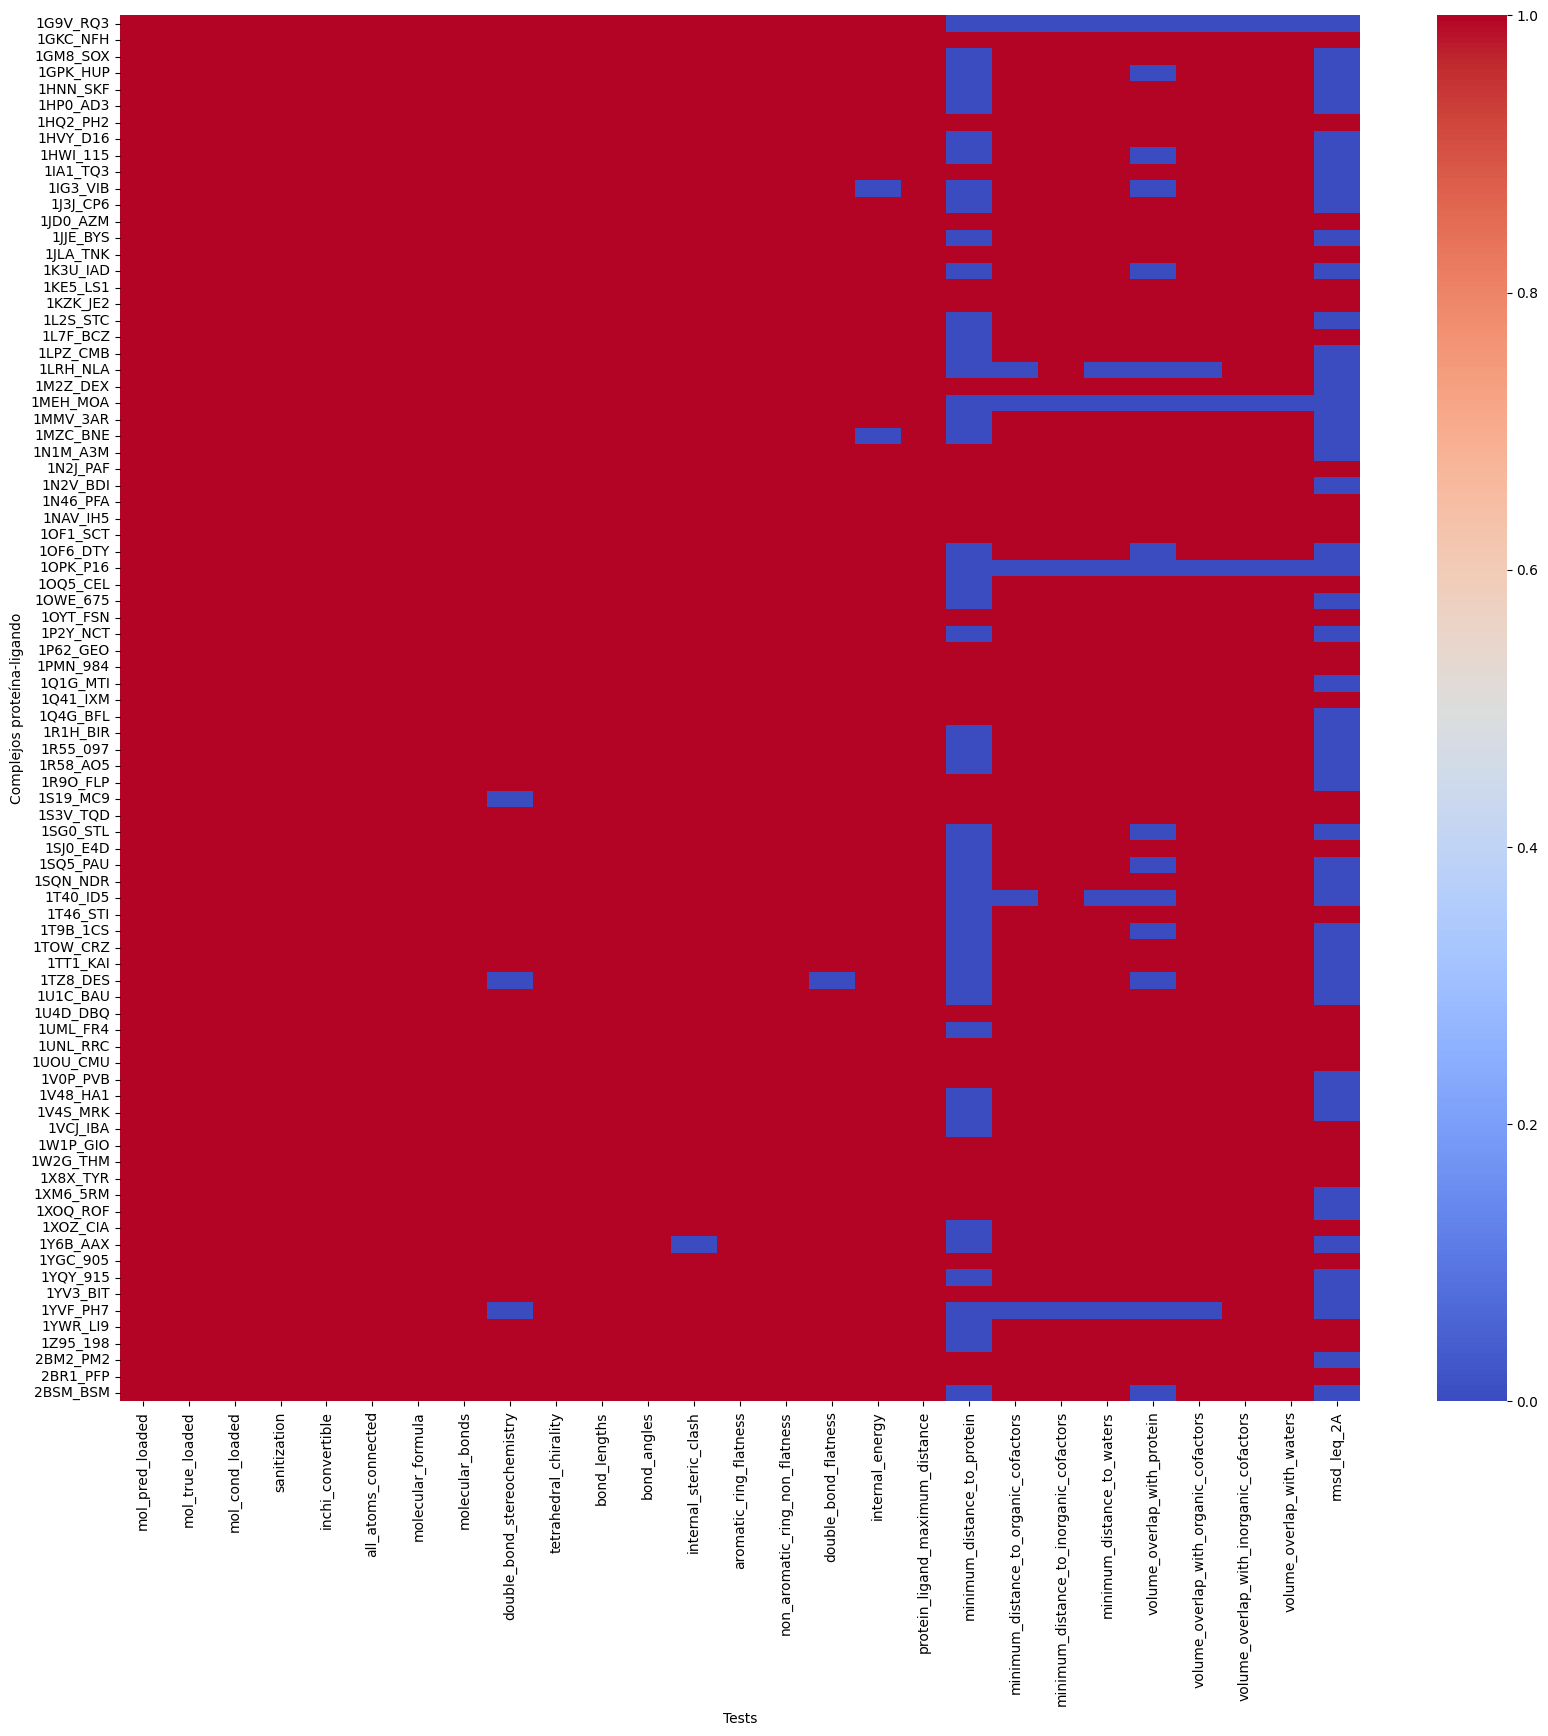

In [15]:
plot_heat_map(diffdock_astex_start)

In [16]:
ligand_list=[
    "data_sets/astex_diverse_set/1HQ2_PH2/1HQ2_PH2_ligand.sdf",
    "data_sets/astex_diverse_set/1HQ2_PH2/1HQ2_PH2_ligand_start_conf.sdf",
    "results/results_astex_start_diffdock/1HQ2_PH2/complex_0/rank1.sdf",
    "results/results_astex_diffdock/1HQ2_PH2/complex_0/rank1.sdf"
]

colors_list=["red", "green", "blue", "orange"]
visualization("data_sets/astex_diverse_set/1HQ2_PH2/1HQ2_PH2_protein.pdb", ligand_list, colors_list)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Resultados EquiBind

#### Ligand

In [17]:
equibind_astex = load_result("results/results_astex_equibind/resultsBust.csv")
equibind_astex

mol_pred_loaded  mol_true_loaded  mol_cond_loaded  sanitization  \
0                                                                           
1G9V_RQ3             True             True             True          True   
1GKC_NFH             True             True             True          True   
1GM8_SOX             True             True             True          True   
1GPK_HUP             True             True             True          True   
1HNN_SKF             True             True             True          True   
...                   ...              ...              ...           ...   
1YWR_LI9             True             True             True          True   
1Z95_198             True             True             True          True   
2BM2_PM2             True             True             True          True   
2BR1_PFP             True             True             True          True   
2BSM_BSM             True             True             True          True   

          inchi_convertible  all_atoms_connected  molecular_formula  \
0                                                                     
1G9V_RQ3               True                 True               True   
1GKC_NFH               True                 True               True   
1GM8_SOX               True                 True               True   
1GPK_HUP               True                 True               True   
1HNN_SKF               True                 True               True   
...                     ...                  ...                ...   
1YWR_LI9               True                 True               True   
1Z95_198               True                 True               True   
2BM2_PM2               True                 True               True   
2BR1_PFP               True                 True               True   
2BSM_BSM               True                 True               True   

          molecular_bonds  double_bond_stereochemistry  tetrahedral_chirality  \
0                                                                               
1G9V_RQ3             True                         True                   True   
1GKC_NFH             True                         True                   True   
1GM8_SOX             True                         True                   True   
1GPK_HUP             True                         True                   True   
1HNN_SKF             True                         True                   True   
...                   ...                          ...                    ...   
1YWR_LI9             True                         True                   True   
1Z95_198             True                         True                   True   
2BM2_PM2             True                         True                   True   
2BR1_PFP             True                         True                   True   
2BSM_BSM             True                         True                   True   

          ...  protein_ligand_maximum_distance  minimum_distance_to_protein  \
0         ...                                                                 
1G9V_RQ3  ...                             True                        False   
1GKC_NFH  ...                             True                        False   
1GM8_SOX  ...                             True                        False   
1GPK_HUP  ...                             True                        False   
1HNN_SKF  ...                             True                        False   
...       ...                              ...                          ...   
1YWR_LI9  ...                             True                        False   
1Z95_198  ...                             True                        False   
2BM2_PM2  ...                             True                         True   
2BR1_PFP  ...                             True                        False   
2BSM_BSM  ...                             True                        False   

  

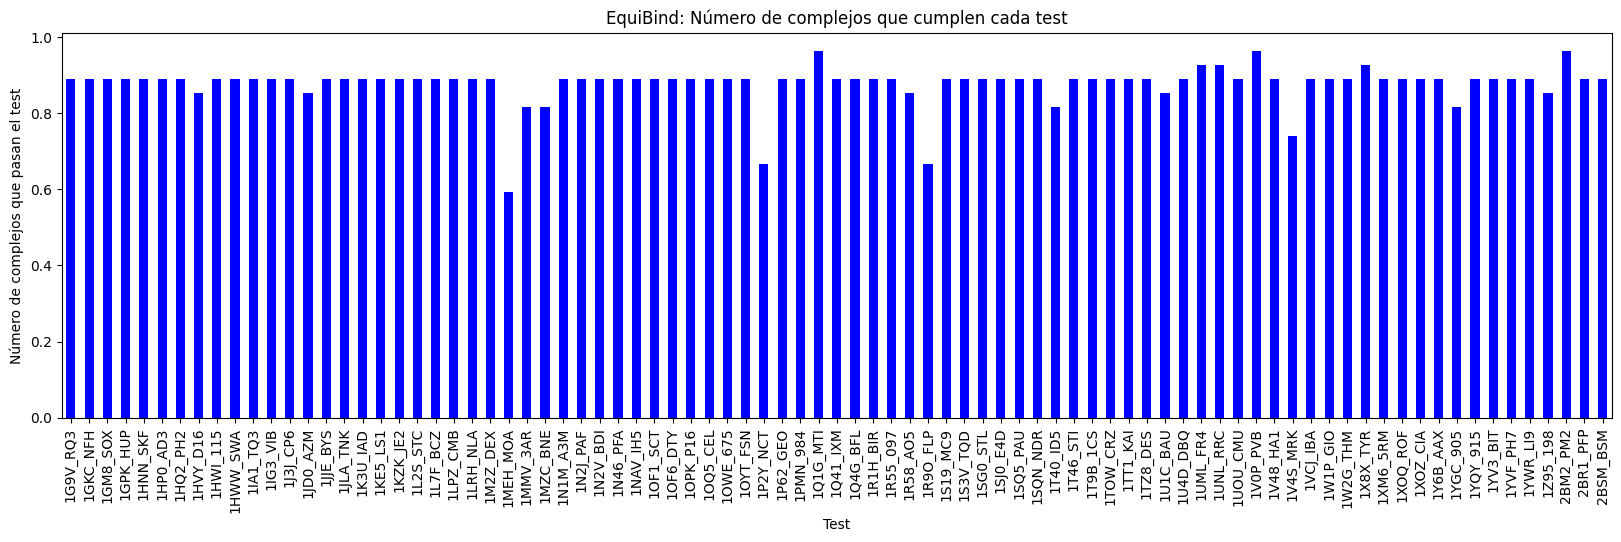

In [18]:
plot_test_test_per_complex(equibind_astex, "EquiBind: Número de complejos que cumplen cada test")

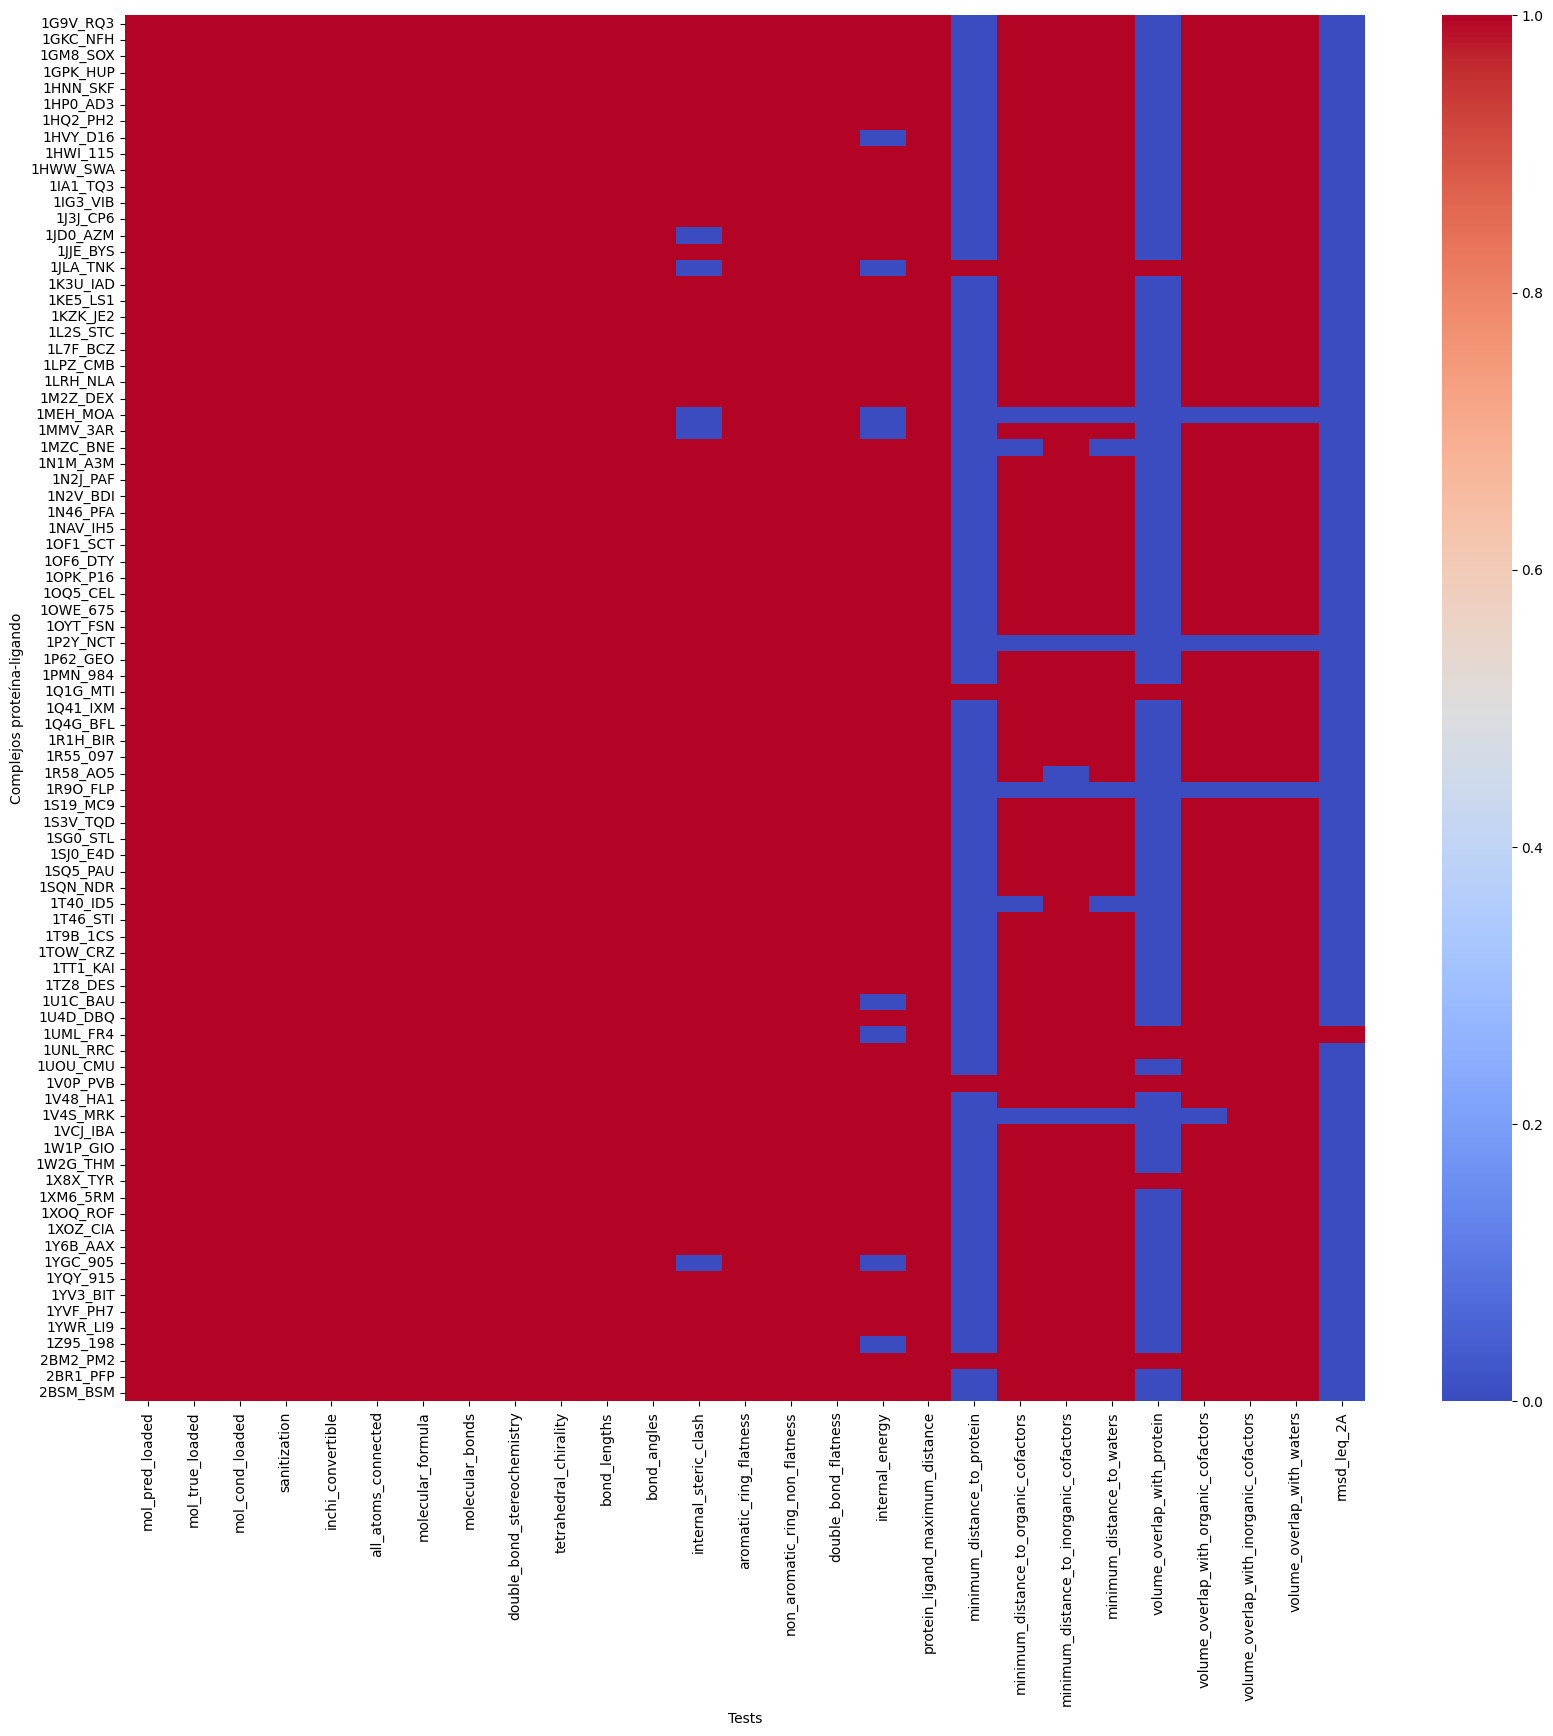

In [19]:
plot_heat_map(equibind_astex)

#### Start Config

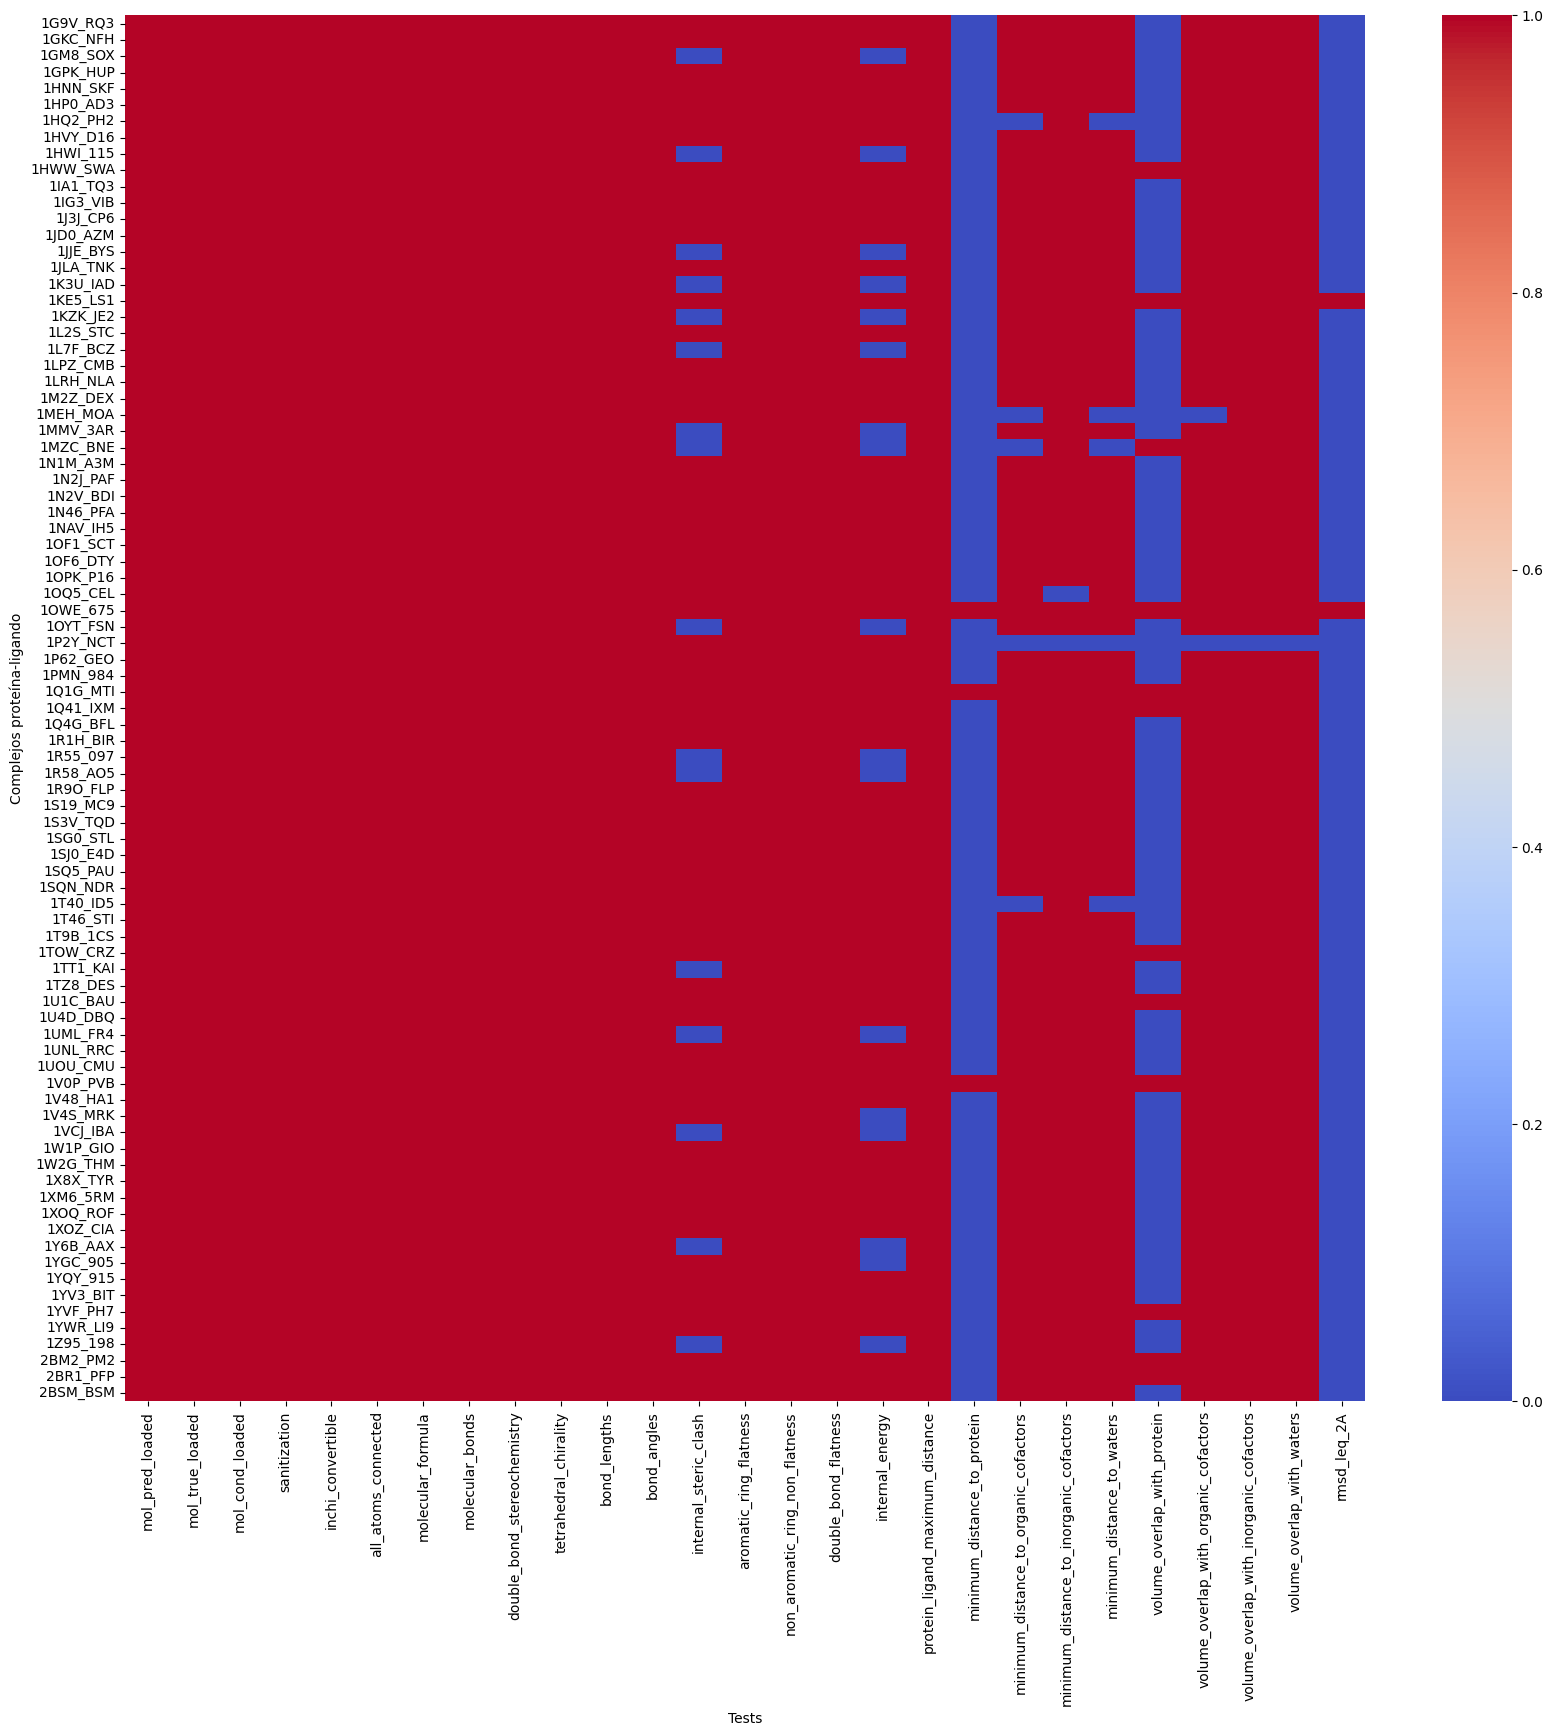

In [20]:
equibind_astex_start = load_result("results/results_astex_start_equibind/resultsBust.csv")
plot_heat_map(equibind_astex_start)

In [21]:
visualization(
    protein_path="data_sets/astex_diverse_set/1KE5_LS1/1KE5_LS1_protein.pdb",
    ligand_list=[
        "data_sets/astex_diverse_set/1KE5_LS1/1KE5_LS1_ligand_start_conf.sdf",
        "data_sets/astex_diverse_set/1KE5_LS1/1KE5_LS1_ligand.sdf",
        "results/results_astex_start_equibind/1KE5_LS1/lig_equibind_corrected.sdf"
    ],
    colors_list=["red", "green", "blue"]
)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Resultados DeepDock

Para algunos sdf no se ha podido realizar el test de posebuster porque se producía un error de unkekulized atoms. 

#### Ligand

In [22]:
deepdock_astex = load_result("/home/carmen/docking/results/results_astex_deepdock/resultsBustDeepDock.csv")
deepdock_astex

mol_pred_loaded  mol_true_loaded  mol_cond_loaded  sanitization  \
0                                                                           
1G9V_RQ3             True             True             True          True   
1GKC_NFH             True             True             True          True   
1GM8_SOX             True             True             True          True   
1HNN_SKF             True             True             True          True   
1HWW_SWA             True             True             True          True   
1IA1_TQ3             True             True             True          True   
1J3J_CP6             True             True             True          True   
1JD0_AZM             True             True             True          True   
1JJE_BYS             True             True             True          True   
1KE5_LS1             True             True             True          True   
1KZK_JE2             True             True             True          True   
1L2S_STC             True             True             True          True   
1L7F_BCZ             True             True             True          True   
1LRH_NLA             True             True             True          True   
1M2Z_DEX             True             True             True          True   
1MEH_MOA             True             True             True          True   
1N1M_A3M             True             True             True          True   
1NAV_IH5             True             True             True          True   
1OF6_DTY             True             True             True          True   
1OWE_675             True             True             True          True   
1P2Y_NCT             True             True             True          True   
1Q41_IXM             True             True             True          True   
1Q4G_BFL             True             True             True          True   
1R1H_BIR             True             True             True          True   
1R55_097             True             True             True          True   
1R58_AO5             True             True             True          True   
1R9O_FLP             True             True             True          True   
1S19_MC9             True             True             True          True   
1S3V_TQD             True             True             True          True   
1SG0_STL             True             True             True          True   
1SJ0_E4D             True             True             True          True   
1SQ5_PAU             True             True             True          True   
1SQN_NDR             True             True             True          True   
1T40_ID5             True             True             True          True   
1T46_STI             True             True             True          True   
1T9B_1CS             True             True             True          True   
1TT1_KAI             True             True             True          True   
1TZ8_DES             True             True             True          True   
1V48_HA1             True             True             True          True   
1VCJ_IBA             True             True             True          True   
1W1P_GIO             True             True             True          True   
1X8X_TYR             True             True             True          True   
1XM6_5RM             True             True             True          True   
1XOQ_ROF             True             True             True          True   
1Y6B_AAX             True             True             True          True   
1YGC_905             True             True             True          True   
1YQY_915             True             True             True          True   
1YV3_BIT             True             True             True          True   
1YVF_PH7             True             True             True          True   
1YWR_LI9             True             True             True          True   
1Z95_1

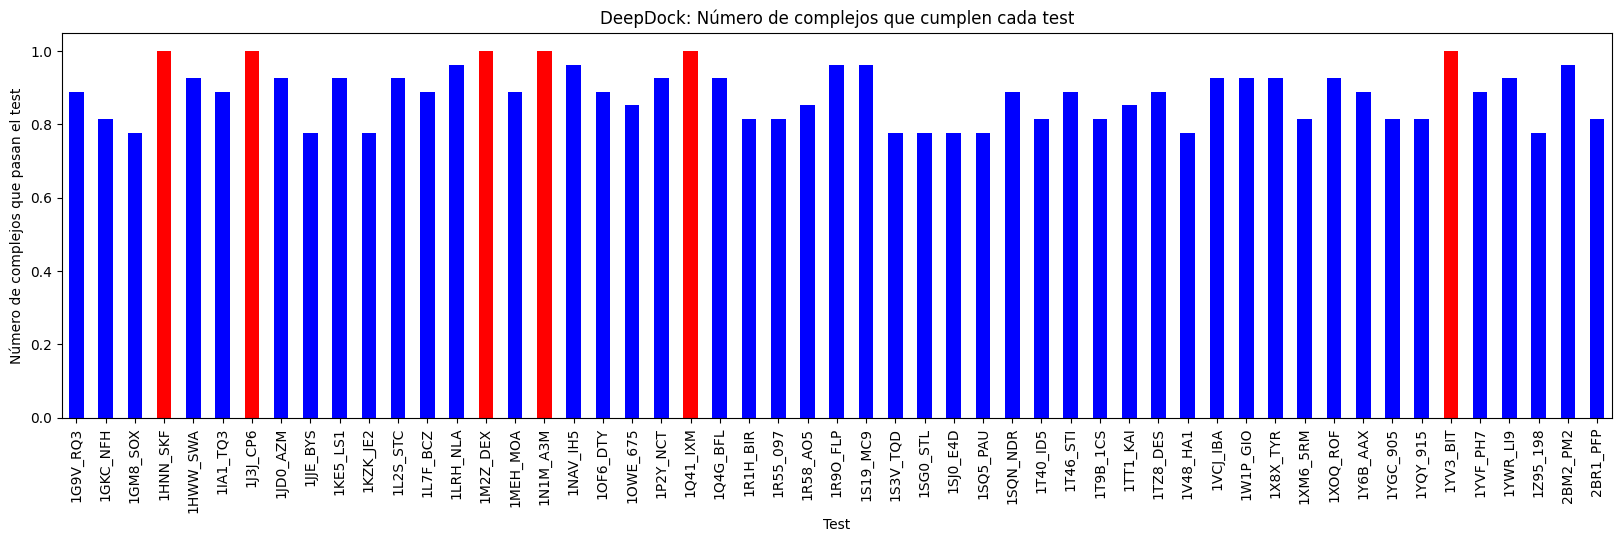

In [23]:
plot_test_test_per_complex(deepdock_astex, "DeepDock: Número de complejos que cumplen cada test")

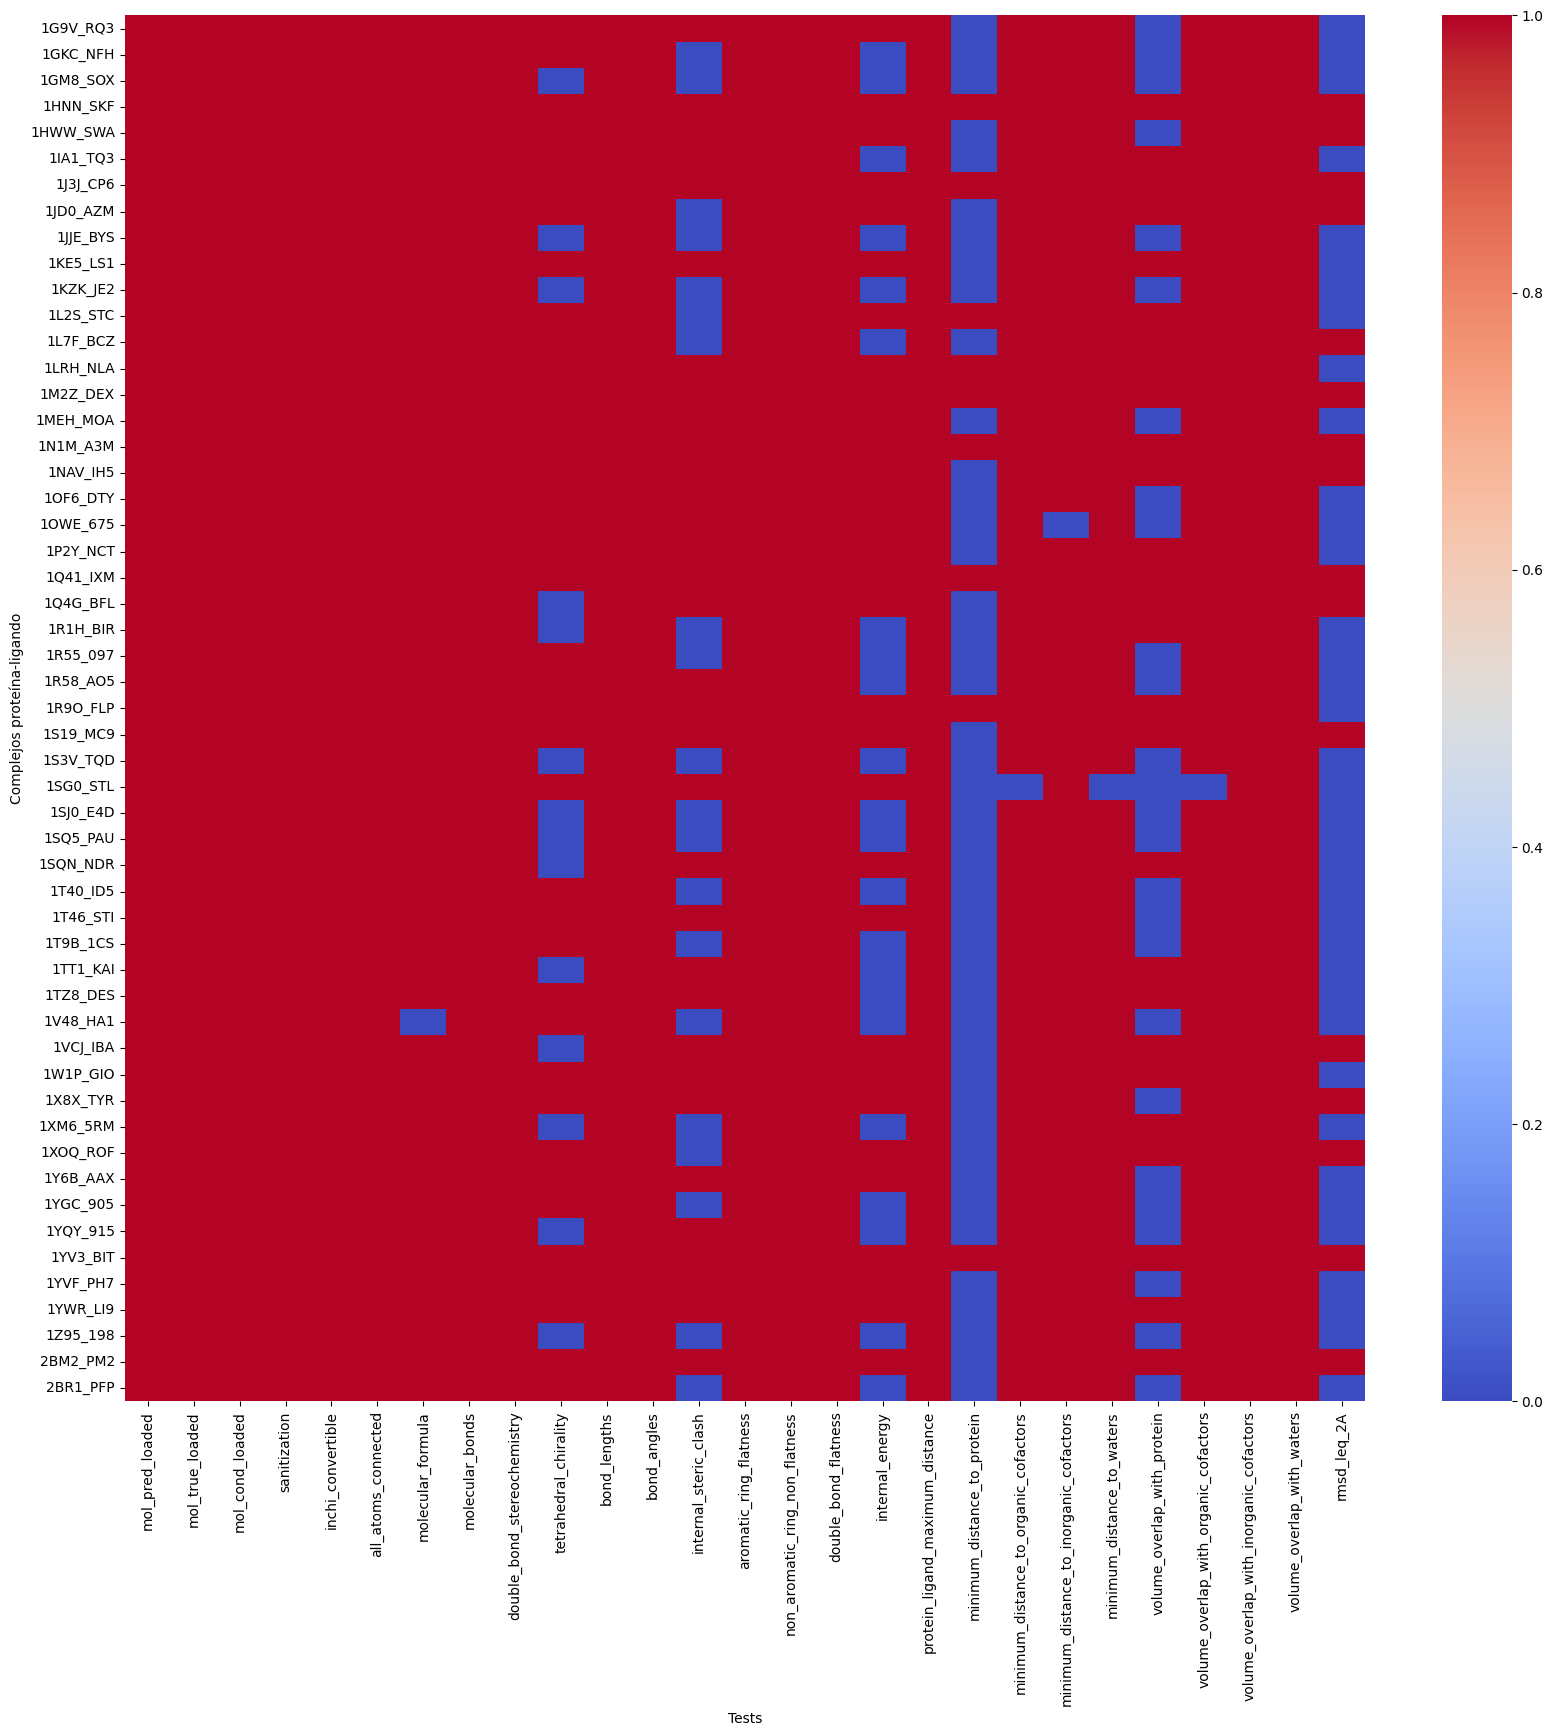

In [24]:
plot_heat_map(deepdock_astex)

#### Start Config

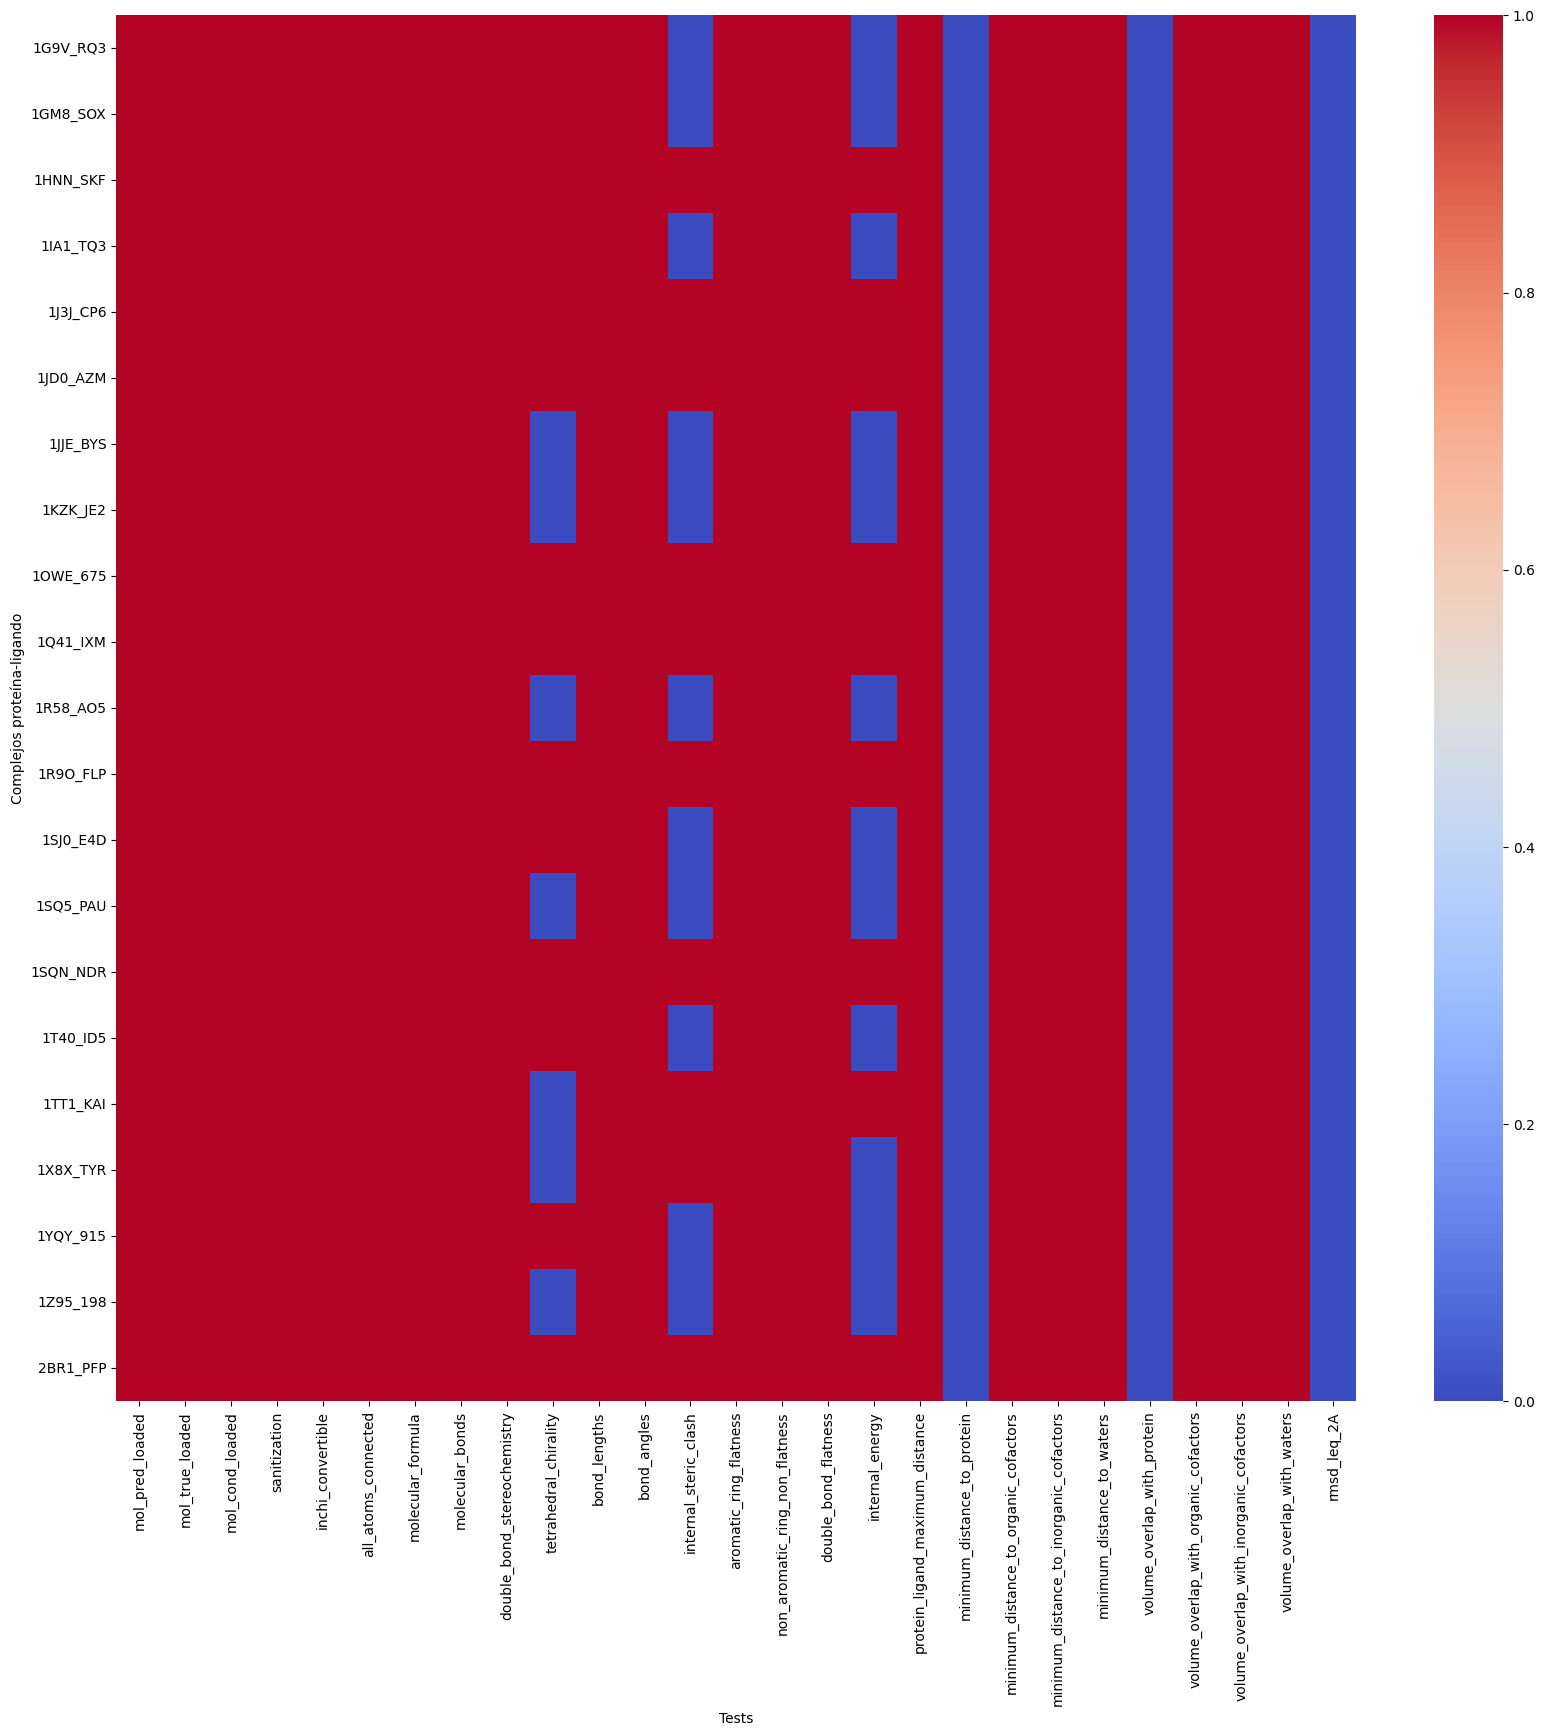

In [25]:
deepdock_astex_start = load_result("/home/carmen/docking/results/results_astex_start_deepdock/resultsBustAstexDeepDockStart.csv")
plot_heat_map(deepdock_astex_start)

### Resultados UniMol

#### Ligand

In [26]:
unimol_astex = load_result("results/results_astex_unimol/resultsBustUniMol.csv")
unimol_astex

mol_pred_loaded  mol_true_loaded  mol_cond_loaded  sanitization  \
0                                                                           
1G9V_RQ3             True             True             True          True   
1GKC_NFH             True             True             True          True   
1GM8_SOX             True             True             True          True   
1HNN_SKF             True             True             True          True   
1HP0_AD3             True             True             True          True   
...                   ...              ...              ...           ...   
1YVF_PH7             True             True             True          True   
1YWR_LI9             True             True             True          True   
1Z95_198             True             True             True          True   
2BM2_PM2             True             True             True          True   
2BR1_PFP             True             True             True          True   

          inchi_convertible  all_atoms_connected  molecular_formula  \
0                                                                     
1G9V_RQ3               True                 True               True   
1GKC_NFH               True                 True               True   
1GM8_SOX               True                 True               True   
1HNN_SKF               True                 True               True   
1HP0_AD3               True                 True               True   
...                     ...                  ...                ...   
1YVF_PH7               True                 True               True   
1YWR_LI9               True                 True               True   
1Z95_198               True                 True               True   
2BM2_PM2               True                 True               True   
2BR1_PFP               True                 True               True   

          molecular_bonds  double_bond_stereochemistry  tetrahedral_chirality  \
0                                                                               
1G9V_RQ3             True                         True                   True   
1GKC_NFH             True                         True                   True   
1GM8_SOX             True                         True                   True   
1HNN_SKF             True                         True                   True   
1HP0_AD3             True                         True                   True   
...                   ...                          ...                    ...   
1YVF_PH7             True                         True                   True   
1YWR_LI9             True                         True                   True   
1Z95_198             True                         True                   True   
2BM2_PM2             True                         True                   True   
2BR1_PFP             True                         True                   True   

          ...  protein_ligand_maximum_distance  minimum_distance_to_protein  \
0         ...                                                                 
1G9V_RQ3  ...                             True                         True   
1GKC_NFH  ...                             True                         True   
1GM8_SOX  ...                             True                         True   
1HNN_SKF  ...                             True                         True   
1HP0_AD3  ...                             True                         True   
...       ...                              ...                          ...   
1YVF_PH7  ...                             True                         True   
1YWR_LI9  ...                             True                         True   
1Z95_198  ...                             True                        False   
2BM2_PM2  ...                             True                         True   
2BR1_PFP  ...                             True                         True   

  

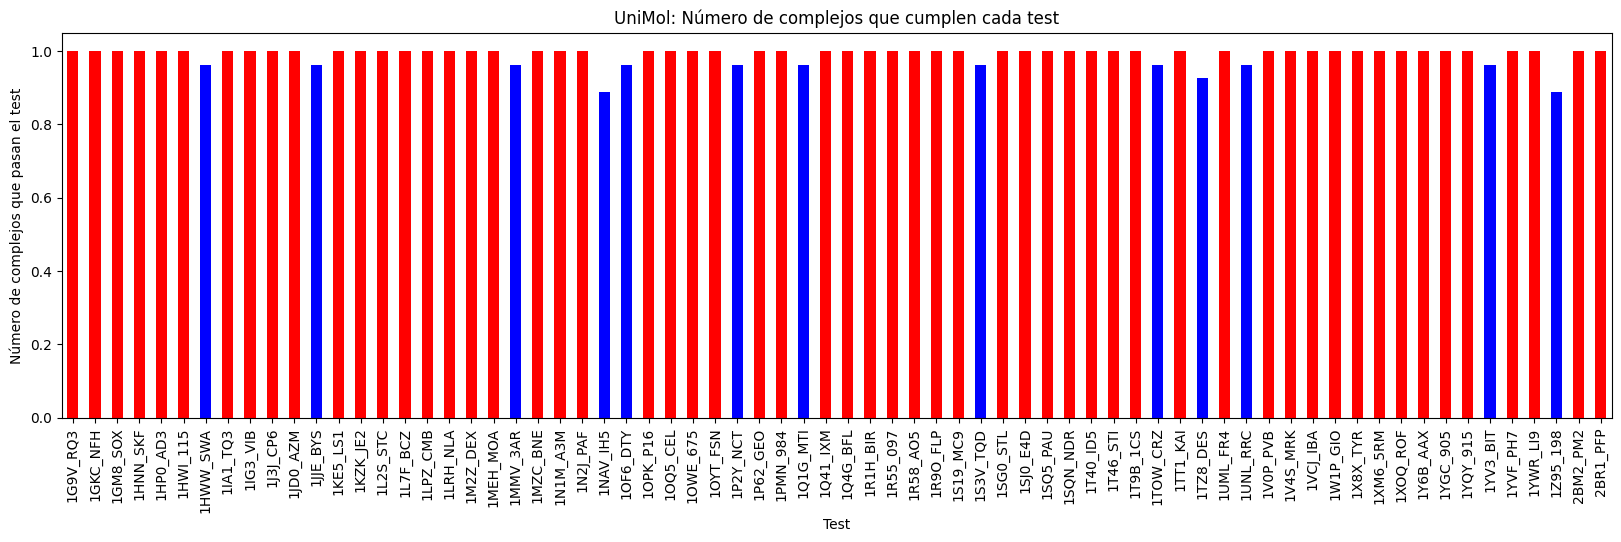

In [27]:
plot_test_test_per_complex(unimol_astex, "UniMol: Número de complejos que cumplen cada test")

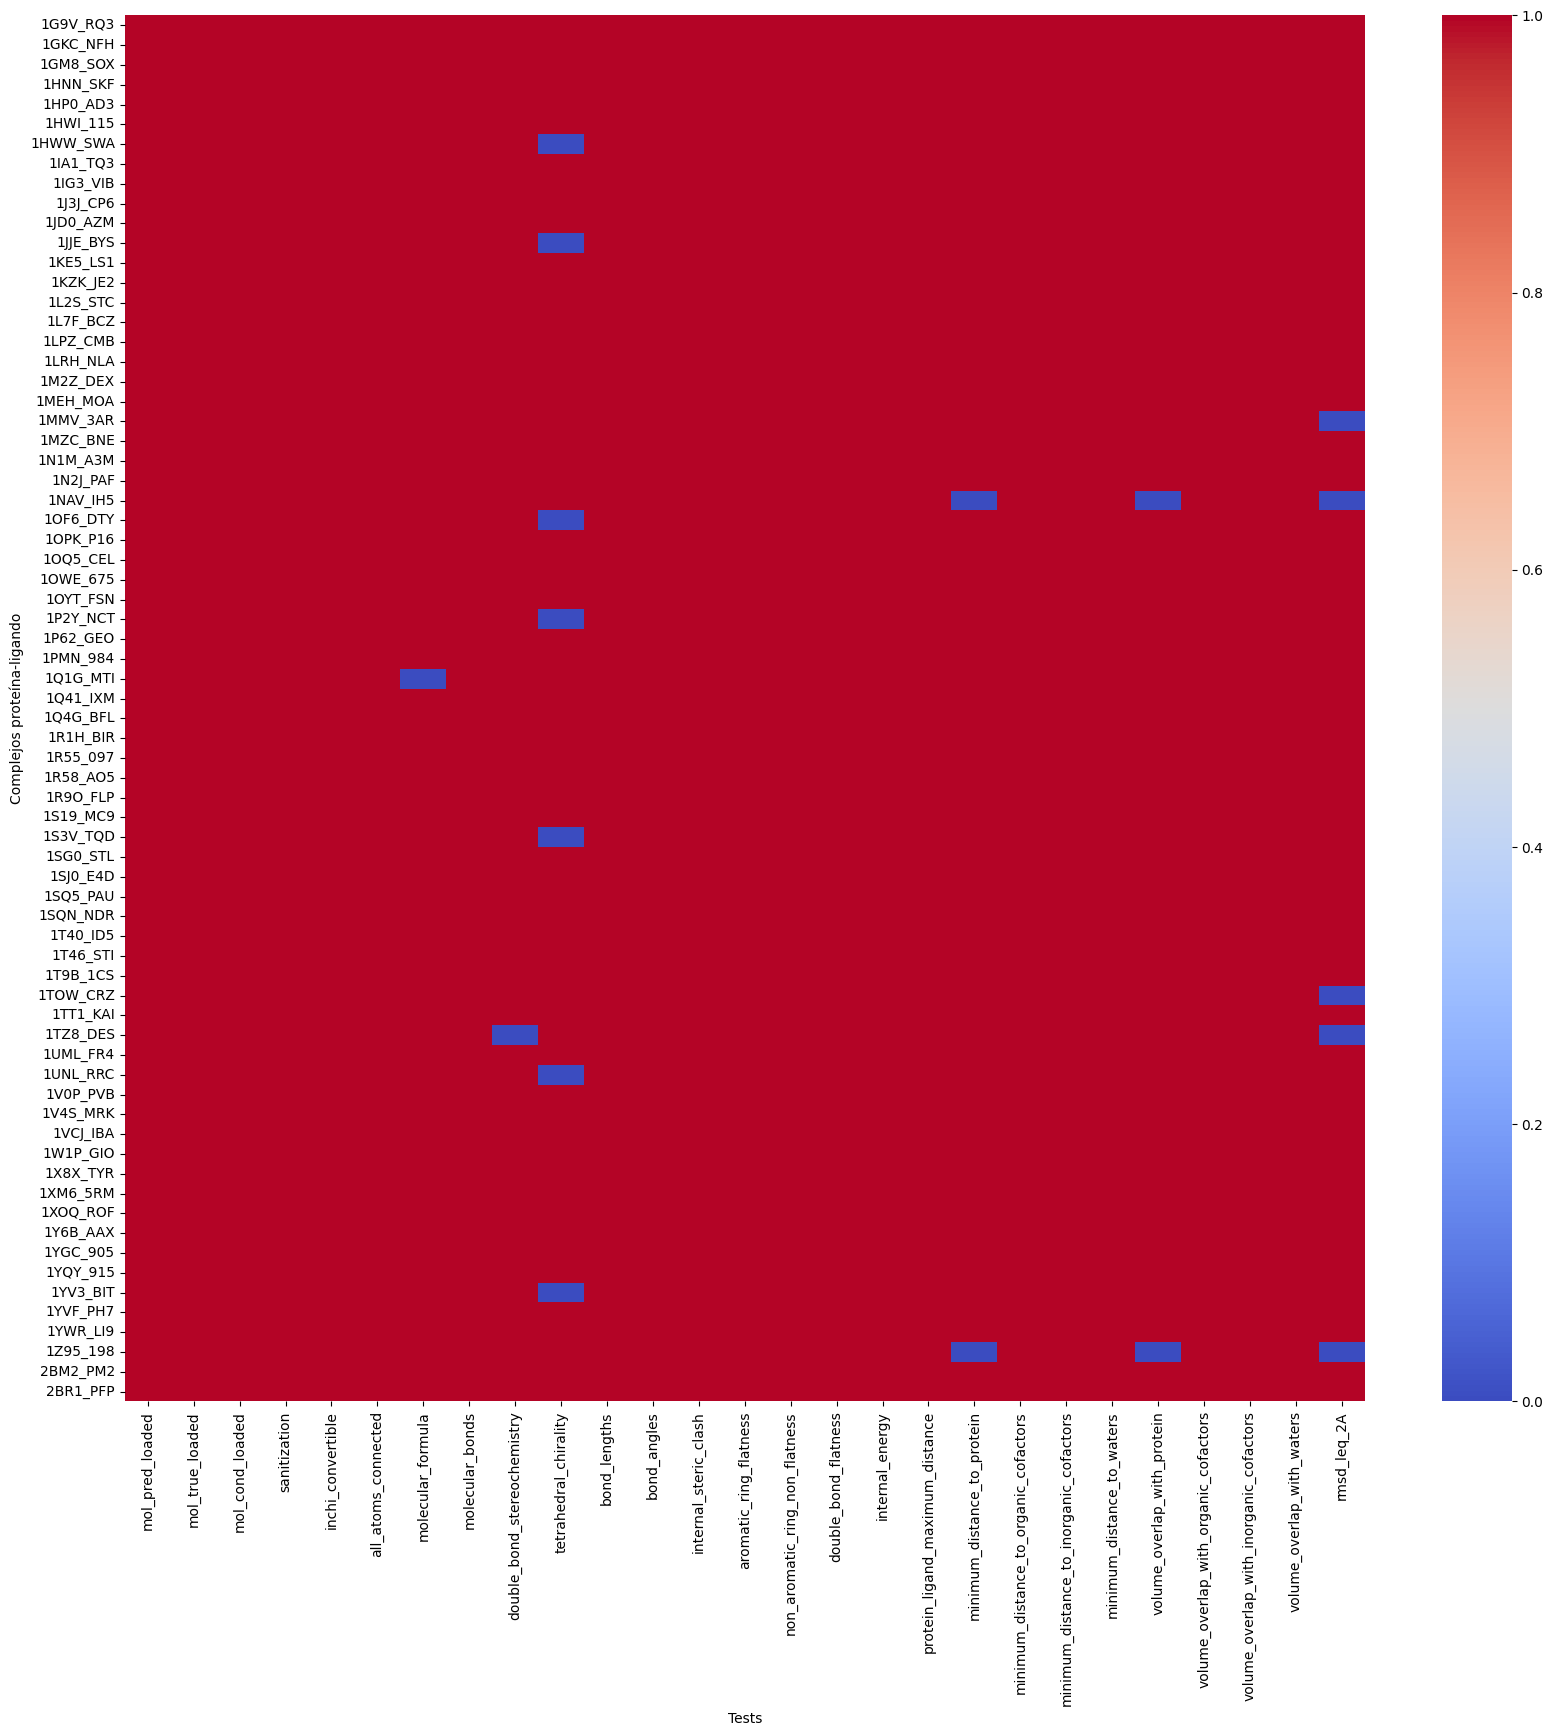

In [28]:
plot_heat_map(unimol_astex)

#### Start Config

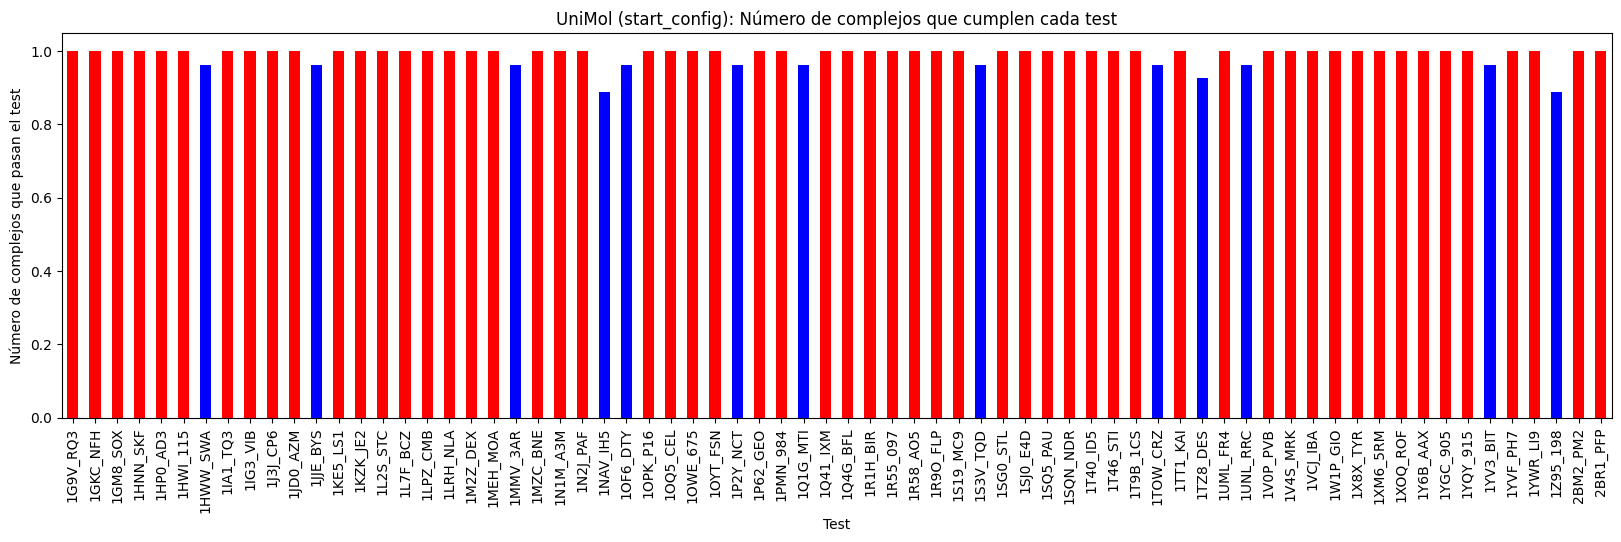

In [29]:
#grid ligand
unimol_astex_start = load_result("results/results_astex_start_unimol/resultsBust.csv")
plot_test_test_per_complex(unimol_astex_start, "UniMol (start_config): Número de complejos que cumplen cada test")

## Comparar los distintos resultados de Astex Diverse Set

/home/carmen/miniconda3/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/carmen/miniconda3/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

<Figure size 1200x600 with 0 Axes>

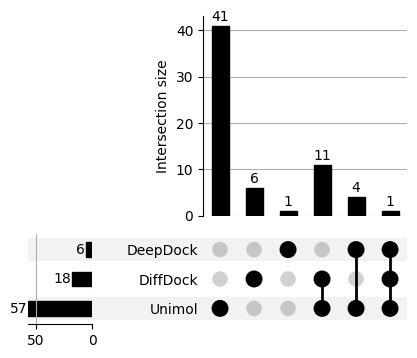

DiffDock  DeepDock  EquiBind  Unimol
1PMN_984      True     False     False    True
1W1P_GIO     False     False     False    True
1KE5_LS1      True     False     False    True
2BM2_PM2     False     False     False    True
1MEH_MOA     False     False     False    True
...            ...       ...       ...     ...
1P62_GEO     False     False     False    True
1T46_STI     False     False     False    True
2BR1_PFP      True     False     False    True
2BSM_BSM      True     False     False   False
1OQ5_CEL     False     False     False    True

[64 rows x 4 columns]

In [30]:
generar_upset_plot(df_dict = {
    "DiffDock": diffdock_astex,
    "DeepDock": deepdock_astex,
    "EquiBind": equibind_astex,
    "Unimol": unimol_astex
})

<Figure size 1000x1000 with 0 Axes>

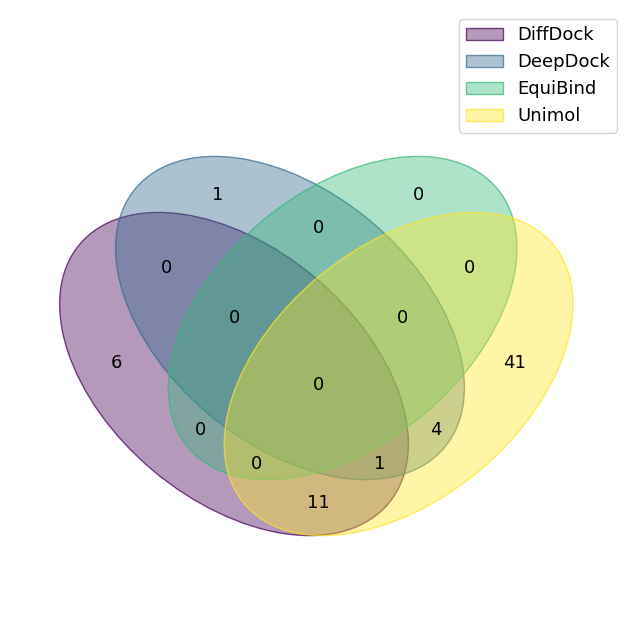

In [37]:
ven_diagramm(df_dict = {
    "DiffDock": diffdock_astex,
    "DeepDock": deepdock_astex,
    "EquiBind": equibind_astex,
    "Unimol": unimol_astex
})


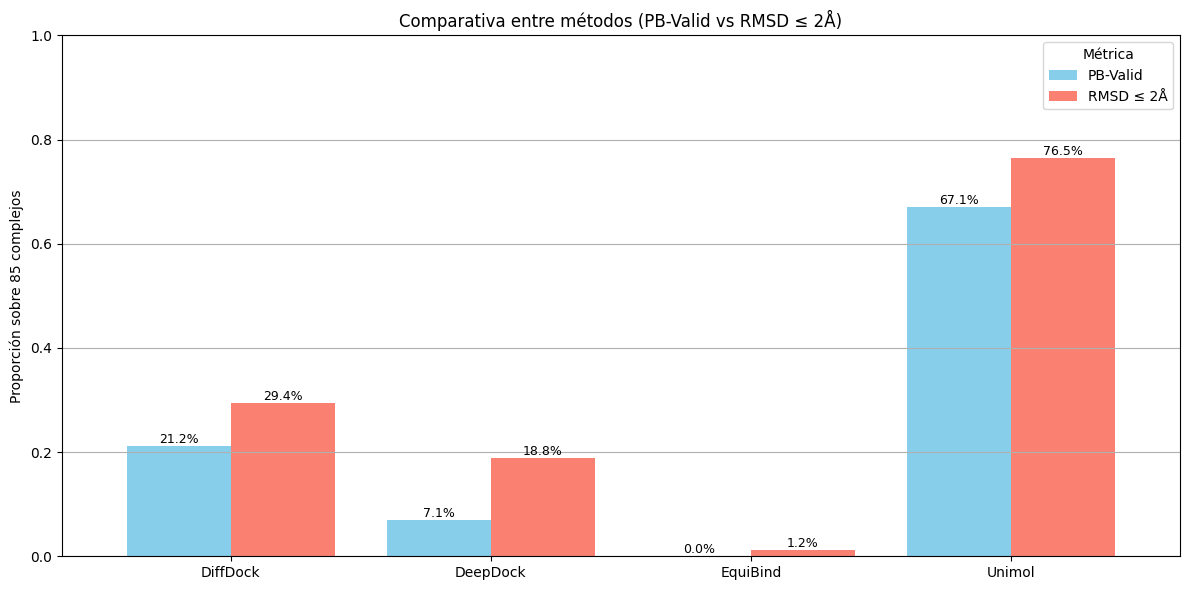

In [40]:

sets = {
    "DiffDock": diffdock_astex,
    "DeepDock": deepdock_astex,
    "EquiBind": equibind_astex,
    "Unimol": unimol_astex
}

compare_tool_diagram(sets, 85)


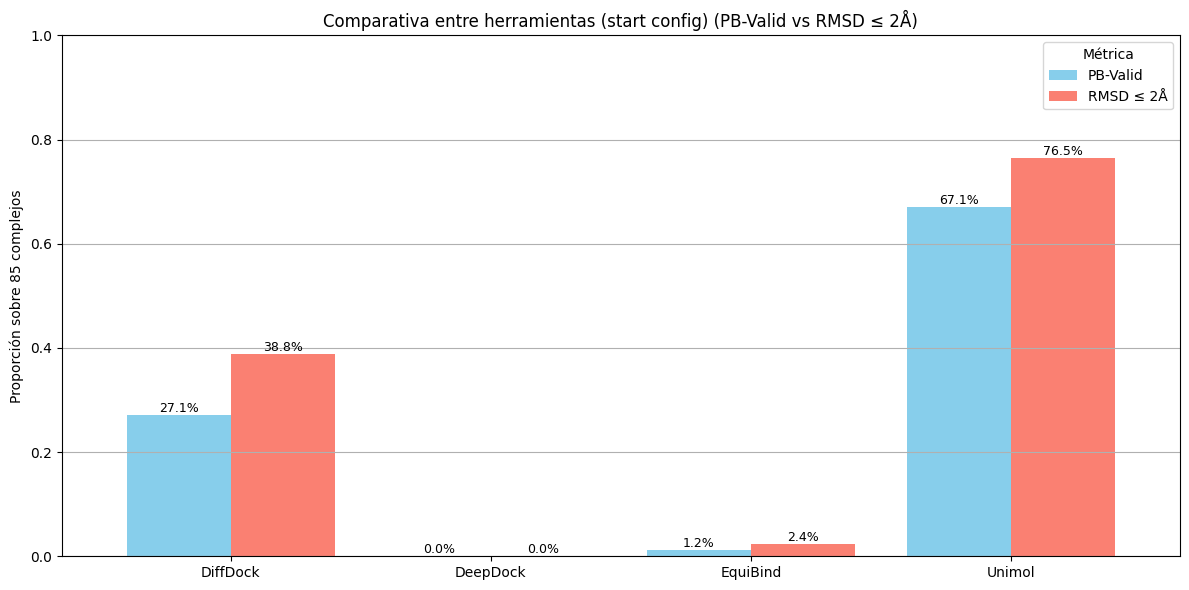

In [43]:

sets_start = {
    "DiffDock": diffdock_astex_start,
    "DeepDock": deepdock_astex_start,
    "EquiBind": equibind_astex_start,
    "Unimol": unimol_astex_start
}

compare_tool_diagram(sets_start, 85, "Comparativa entre herramientas (start config) (PB-Valid vs RMSD ≤ 2Å)" )

## PoseBusters Benchmark Set

Se ha repetido el procedimiento con este conjunto de datos. El articulo de PoseBusters solo usa 307 complejos por lo que se va realizar un filtrado.

### Resultados DiffDock

#### Ligand

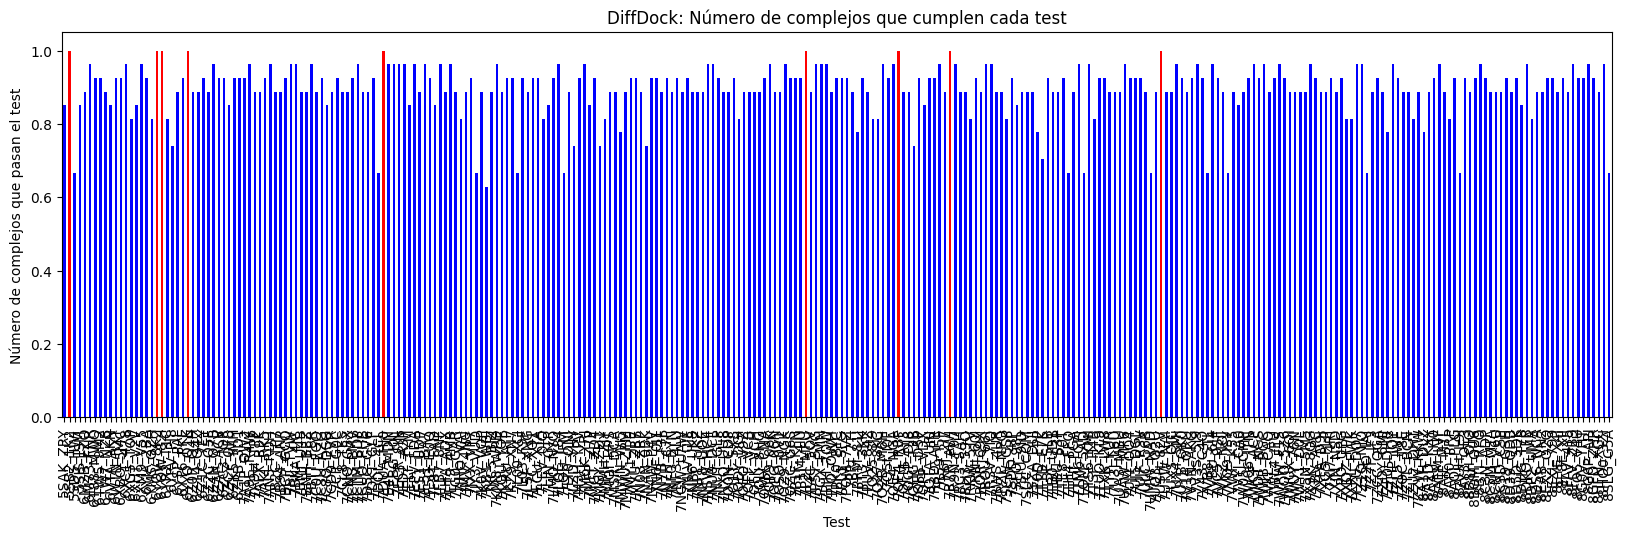

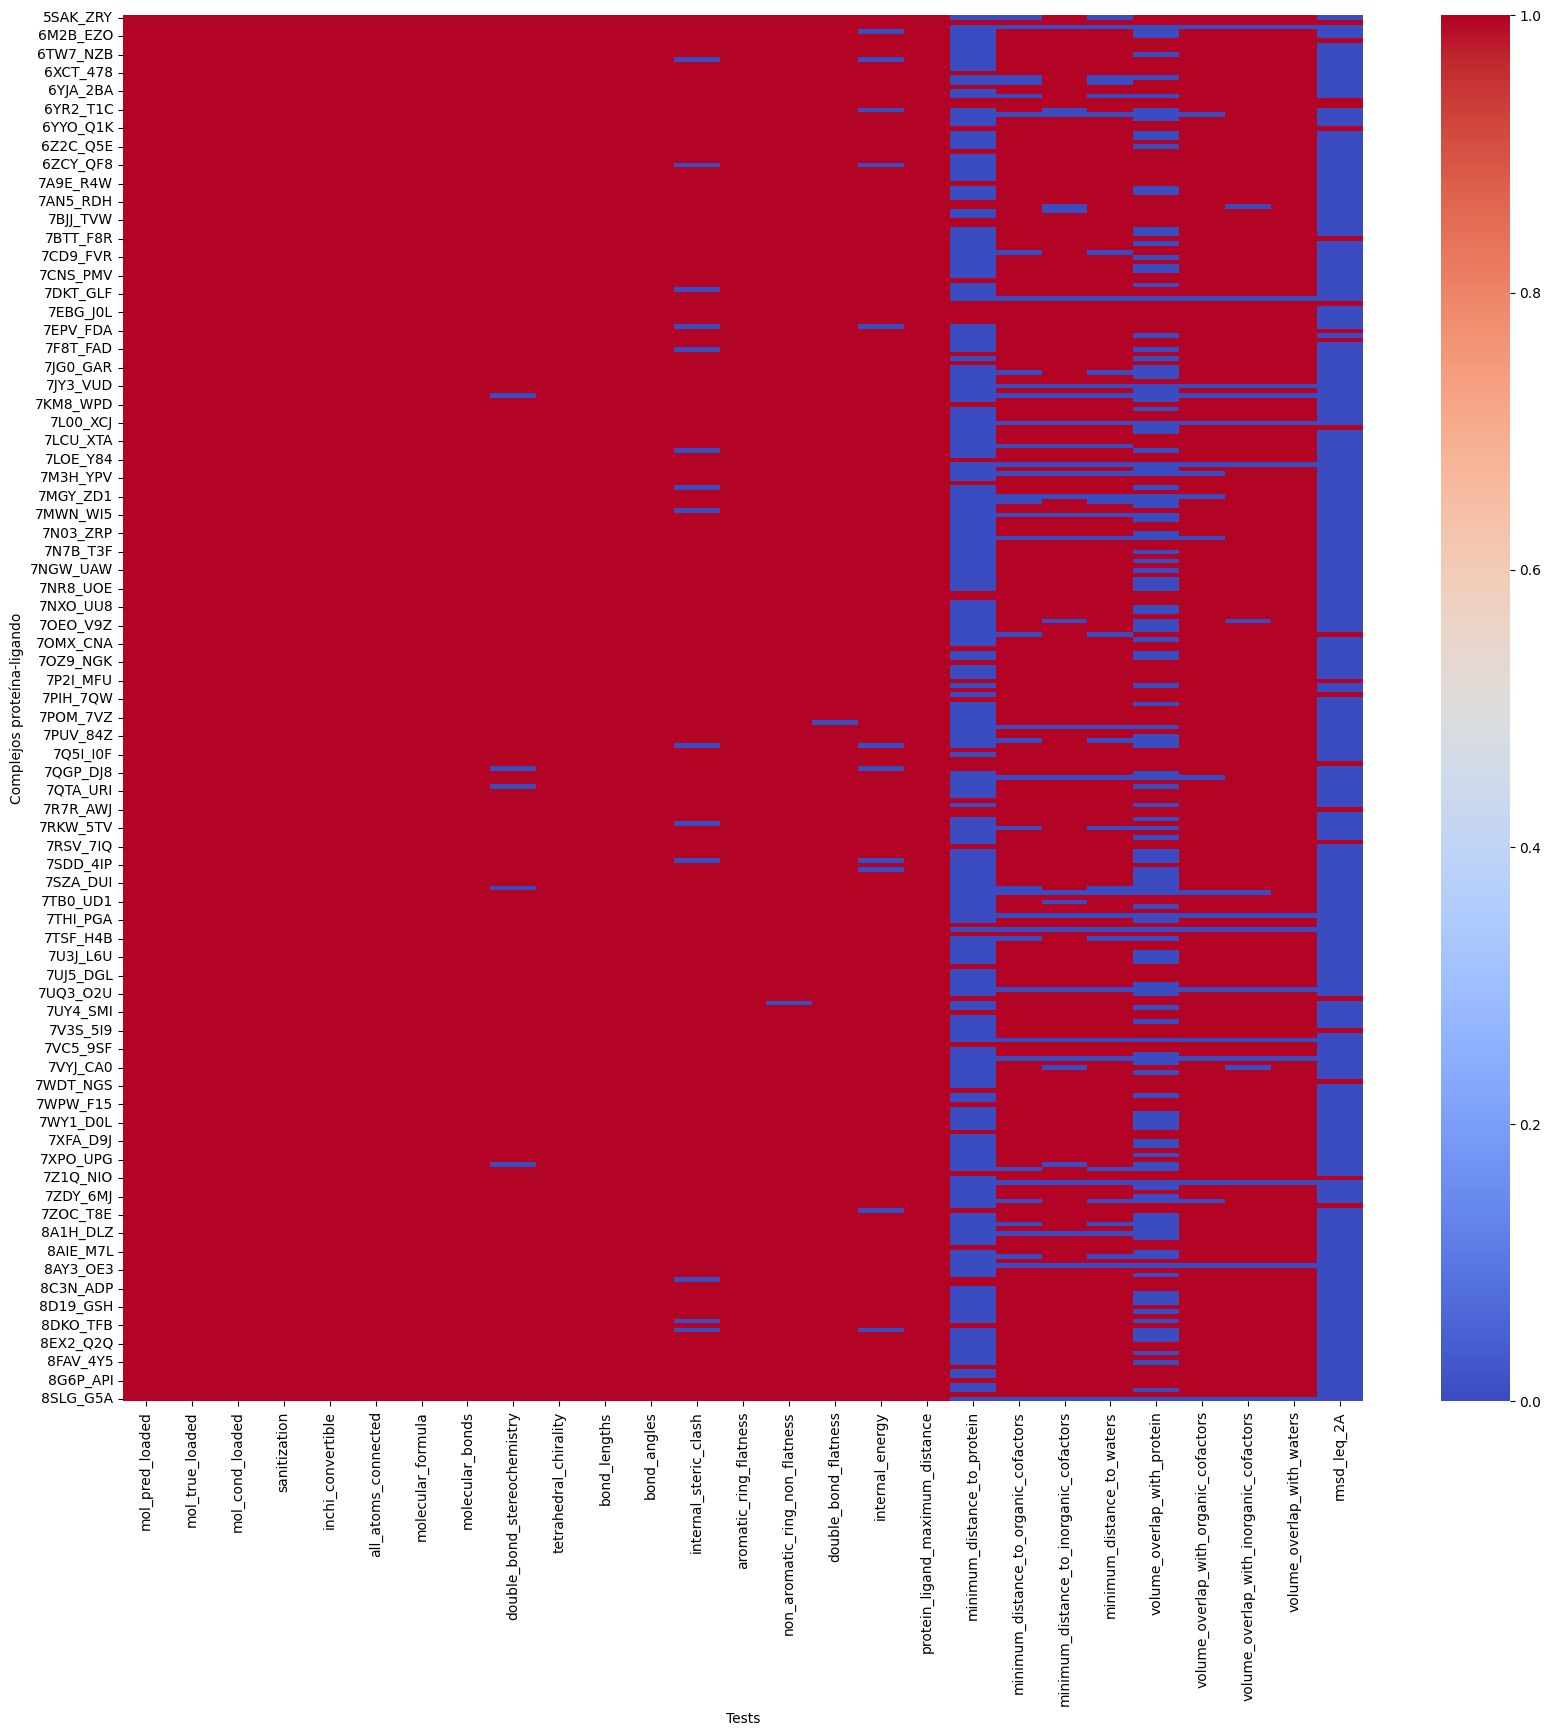

In [46]:
diffdock_pb=filter(load_result("results/results_posebusters_diffdock/evaluation.csv"))
plot_test_test_per_complex(diffdock_pb, "DiffDock: Número de complejos que cumplen cada test")
plot_heat_map(diffdock_pb)

#### Start Config

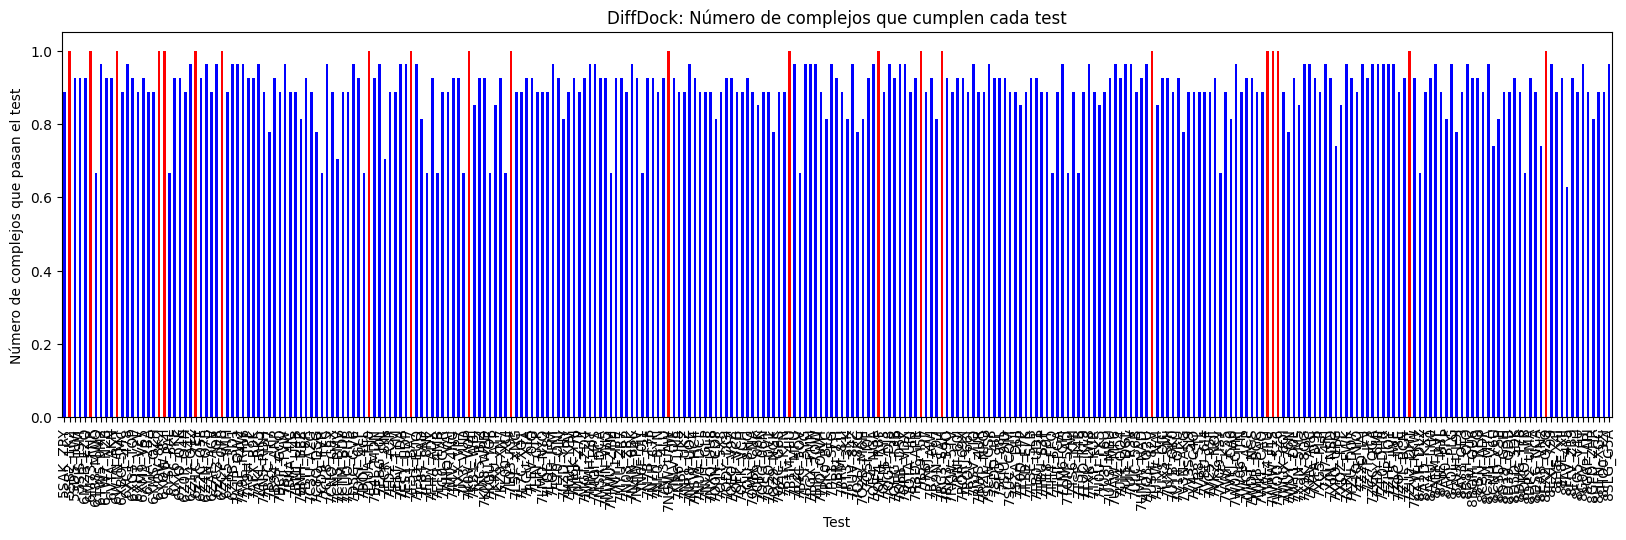

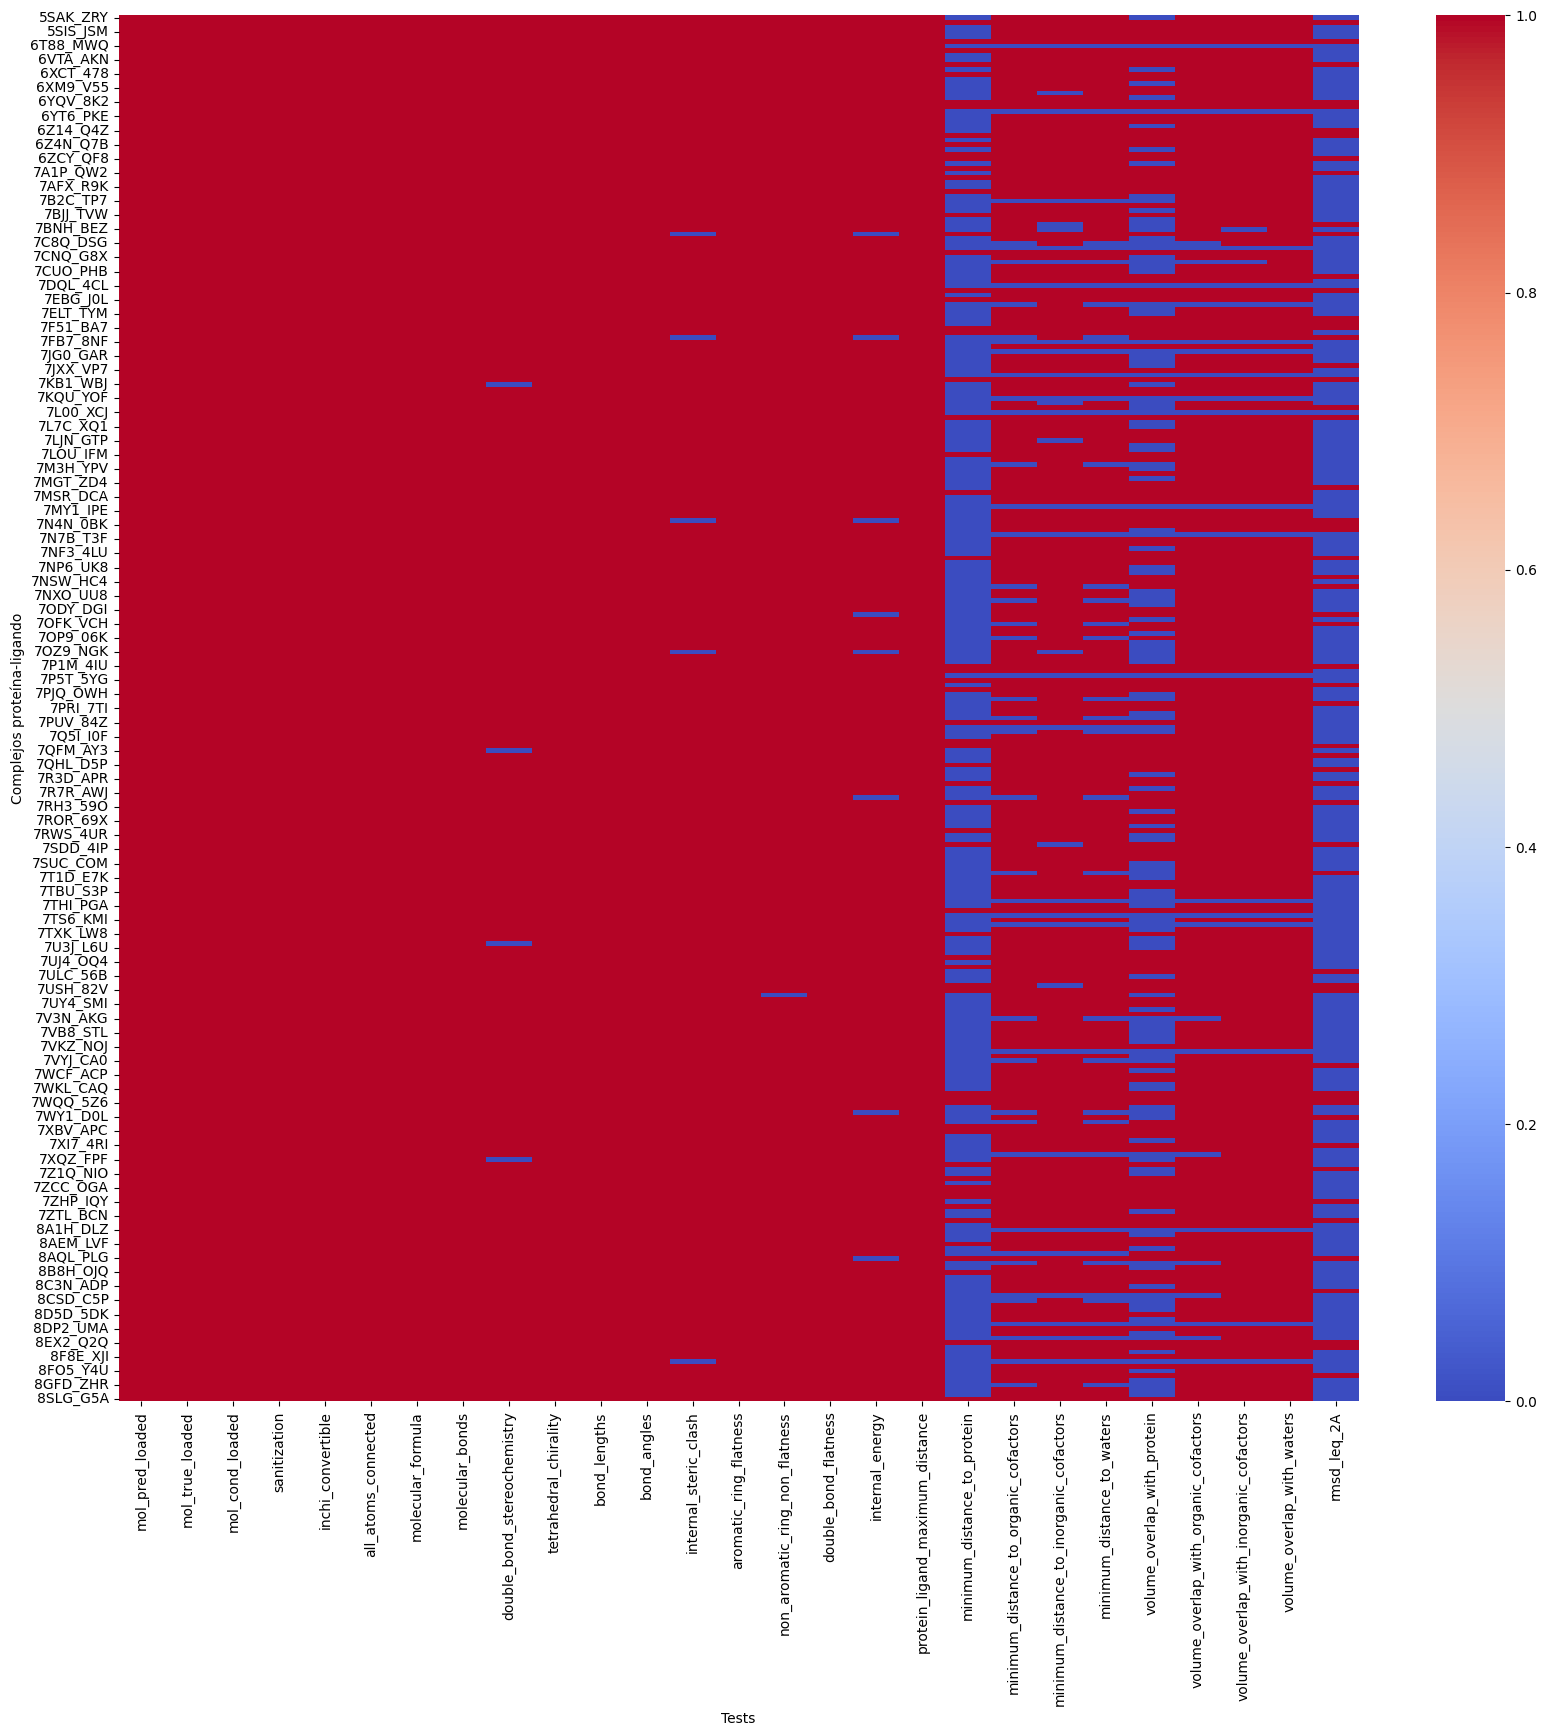

In [48]:
diffdock_pb_start=filter(load_result("results/results_posebusters_start_diffdock/evaluation.csv"))
plot_test_test_per_complex(diffdock_pb_start, "DiffDock: Número de complejos que cumplen cada test")
plot_heat_map(diffdock_pb_start)

### Resultados EquiBind



#### Ligand

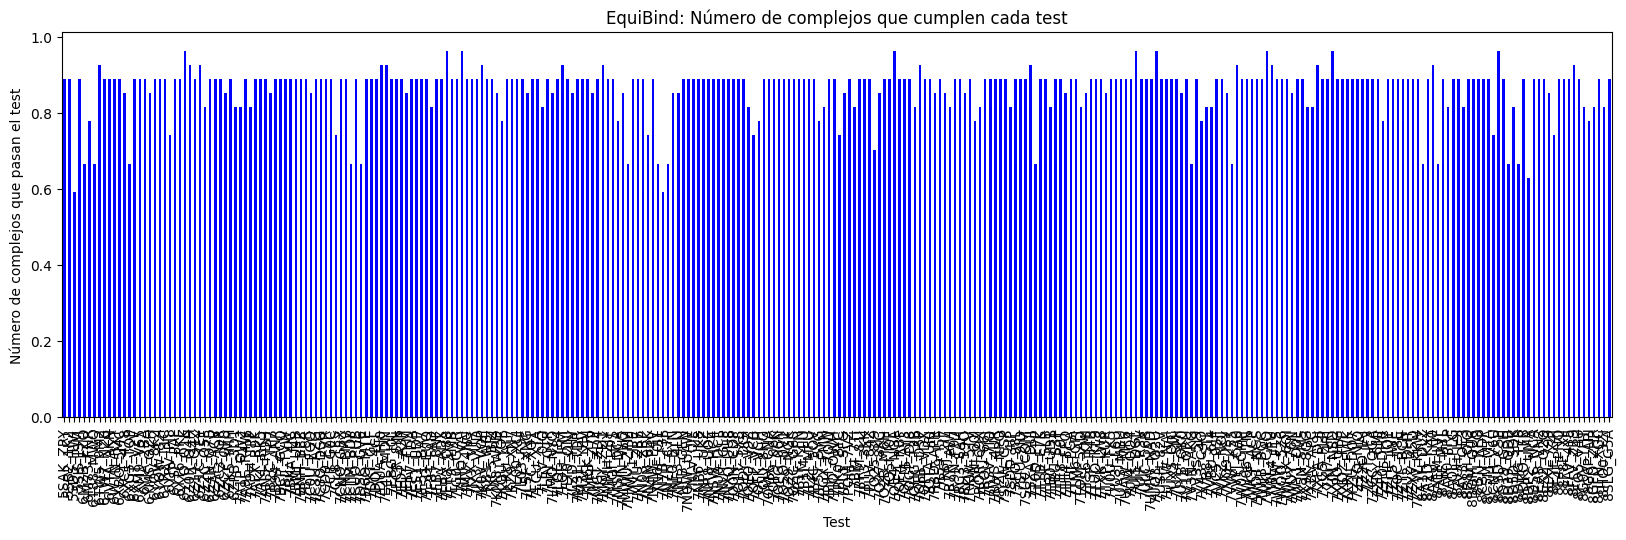

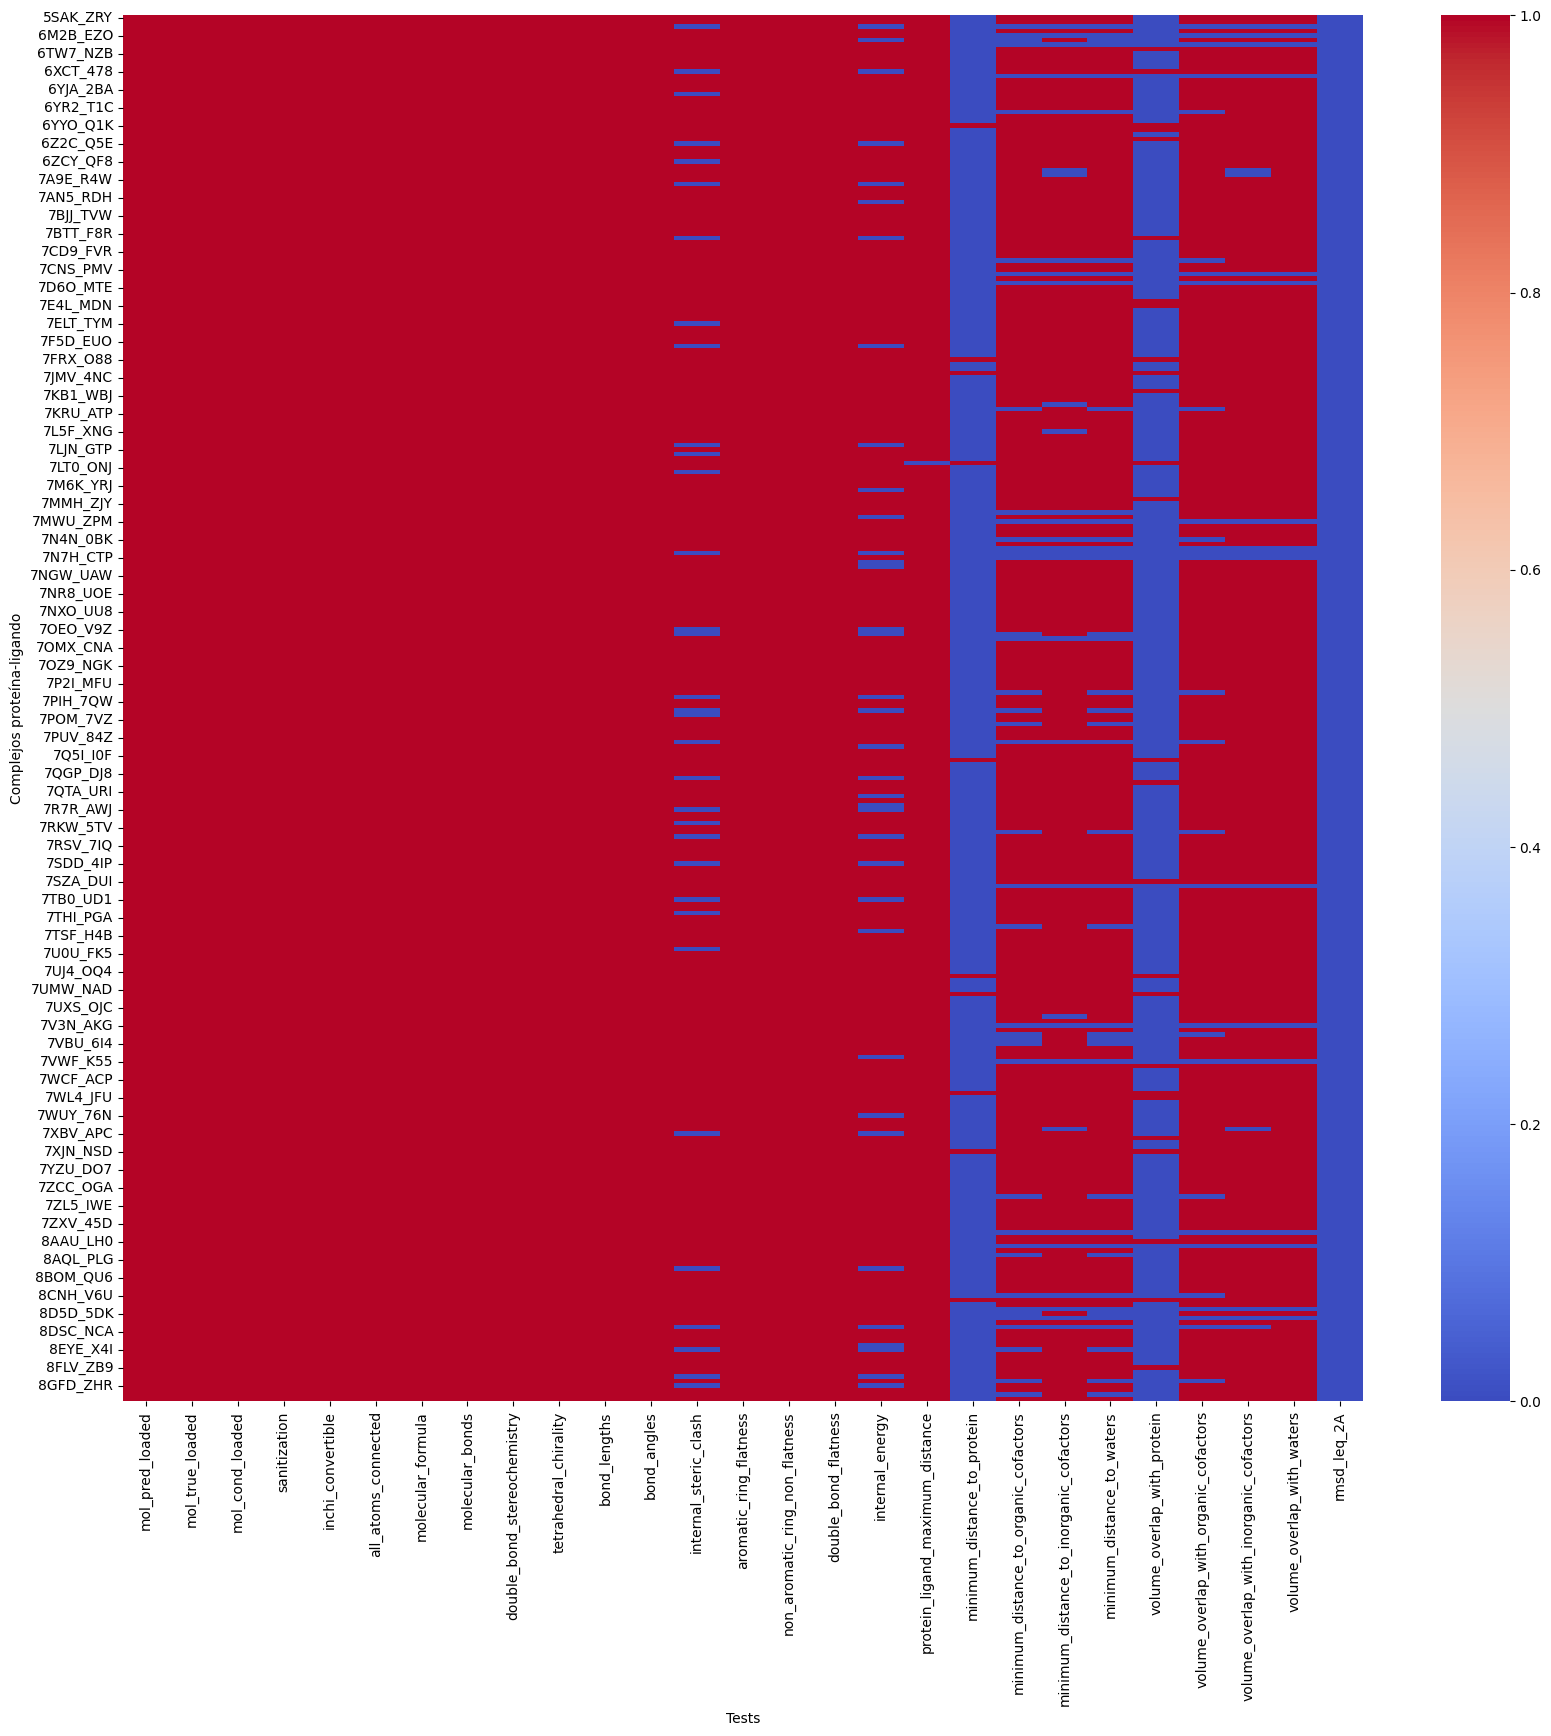

In [49]:
equibind_pb=filter(load_result("results/results_posebusters_equibind/resultsBust.csv"))
plot_test_test_per_complex(equibind_pb, "EquiBind: Número de complejos que cumplen cada test")
plot_heat_map(equibind_pb)

#### Start Config

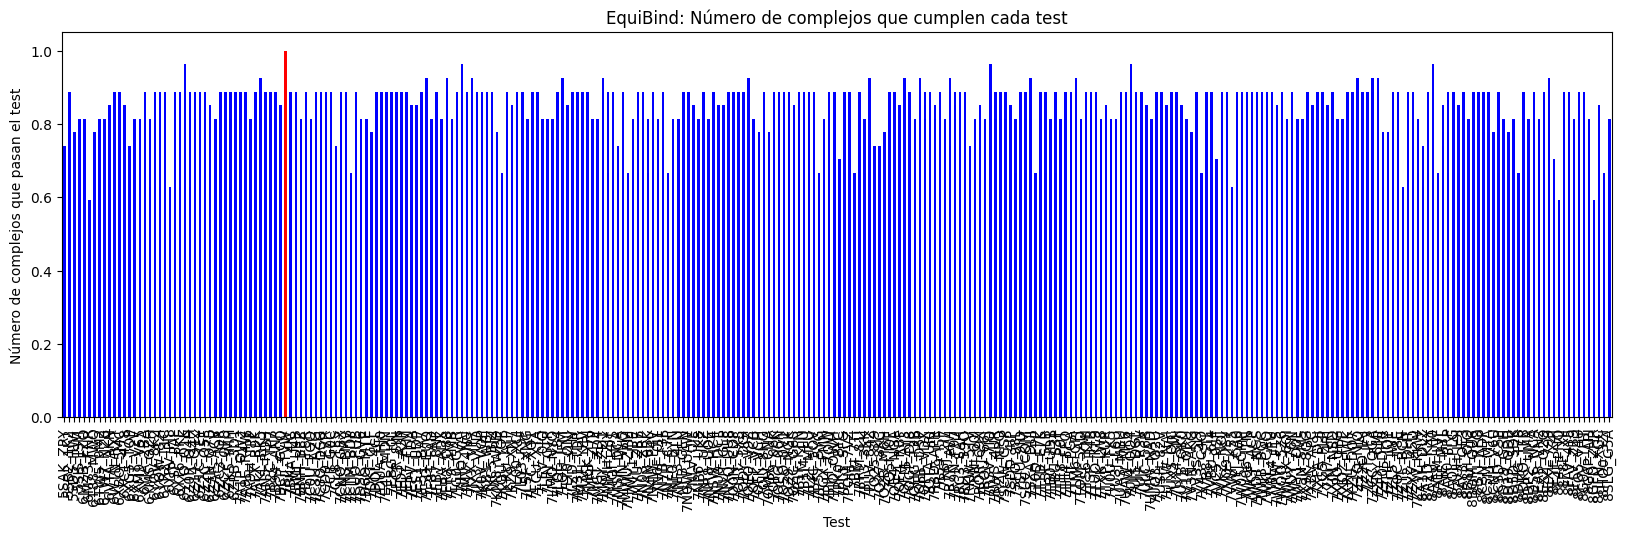

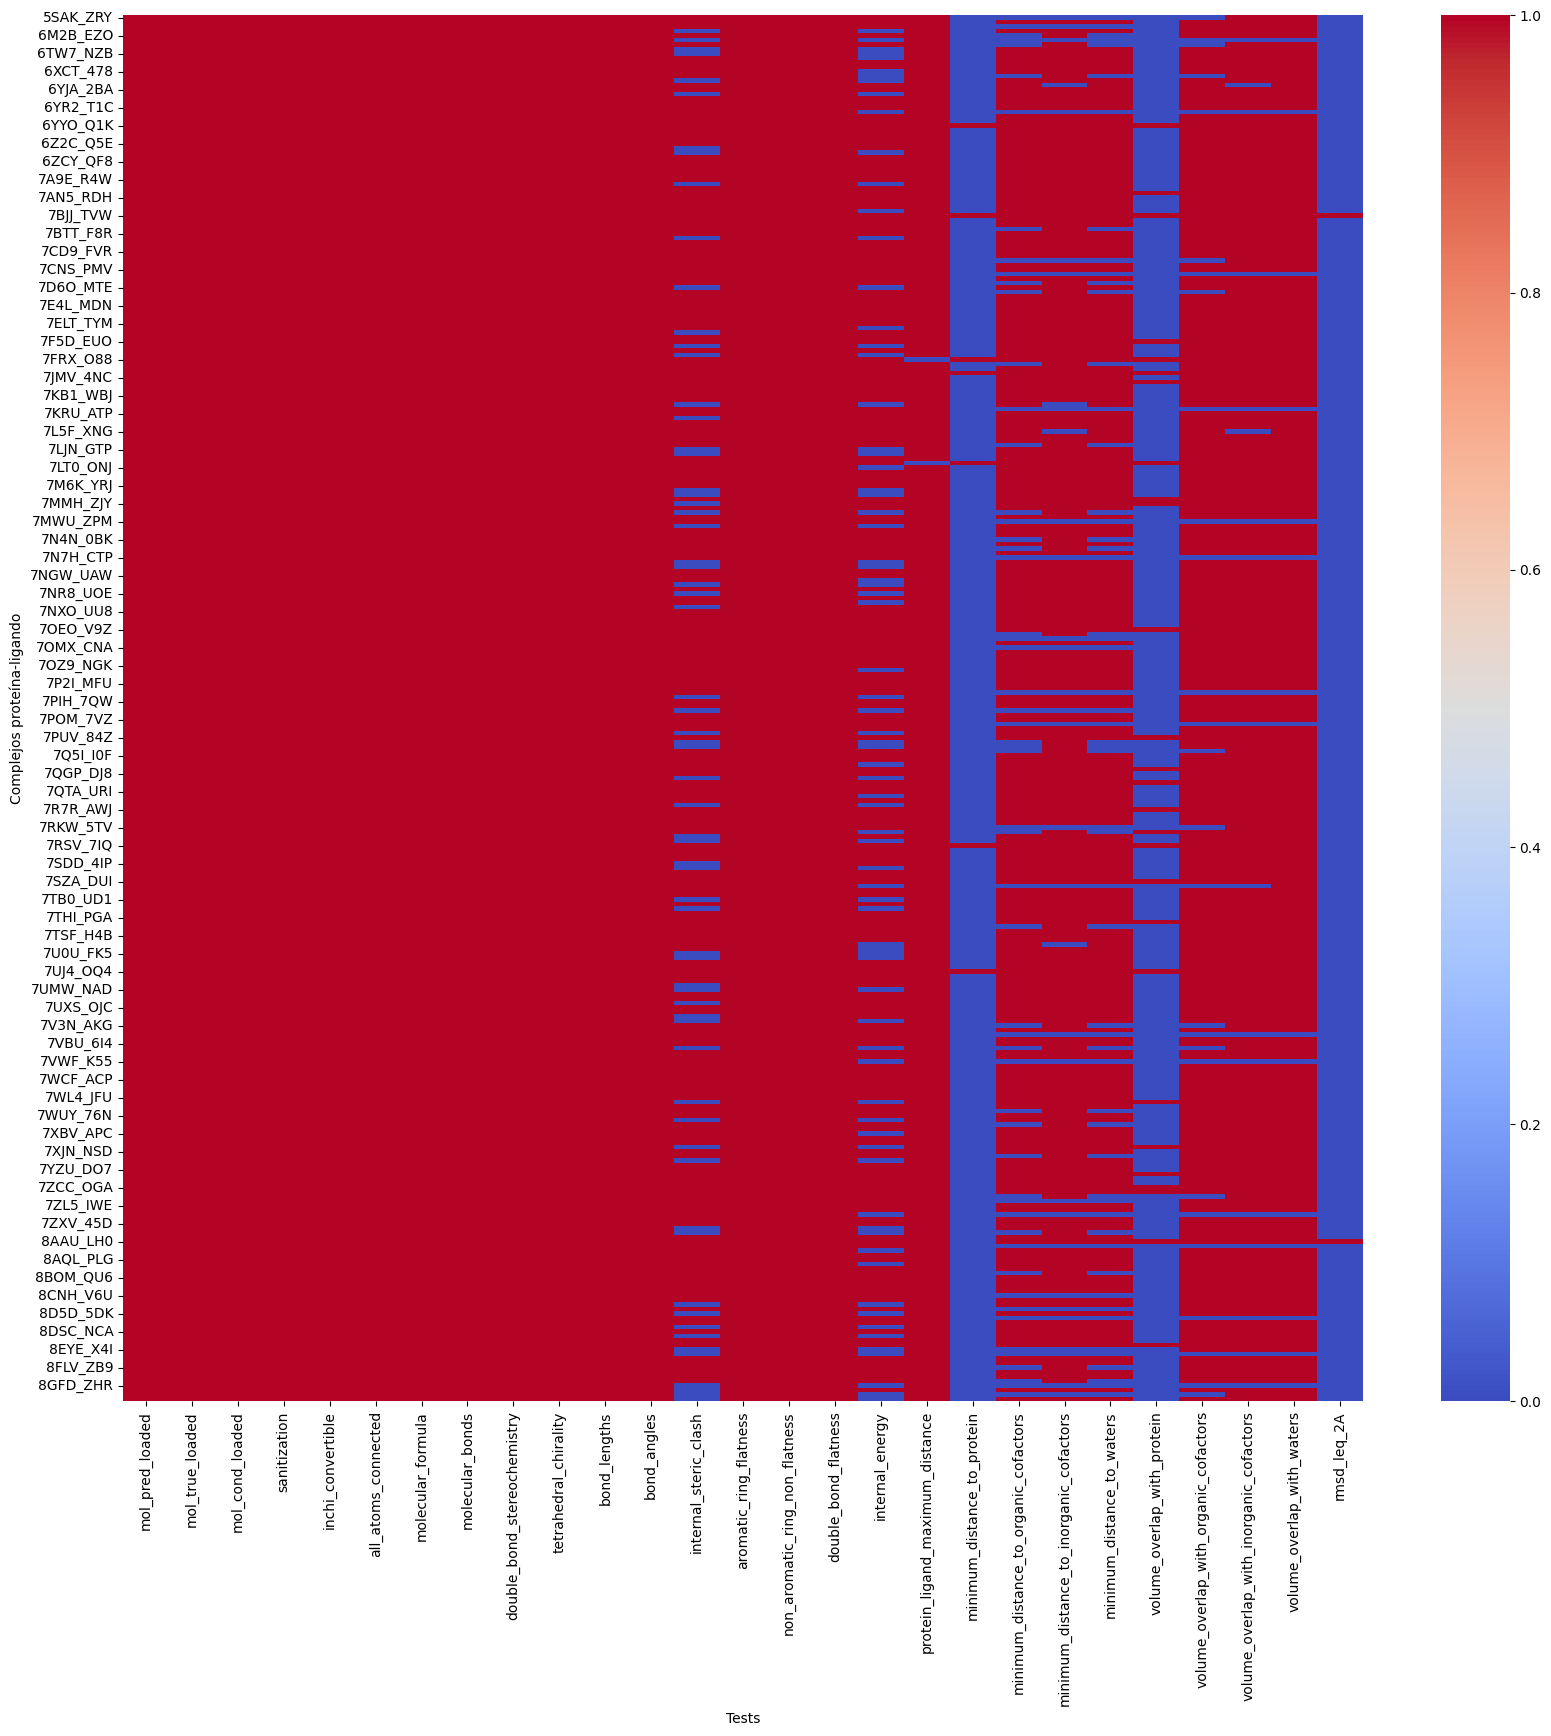

In [50]:
equibind_pb_start=filter(load_result("results/results_posebusters_start_equibind/resultsBust.csv"))
plot_test_test_per_complex(equibind_pb_start, "EquiBind: Número de complejos que cumplen cada test")
plot_heat_map(equibind_pb_start)

### Resultados DeepDock
#### Ligand



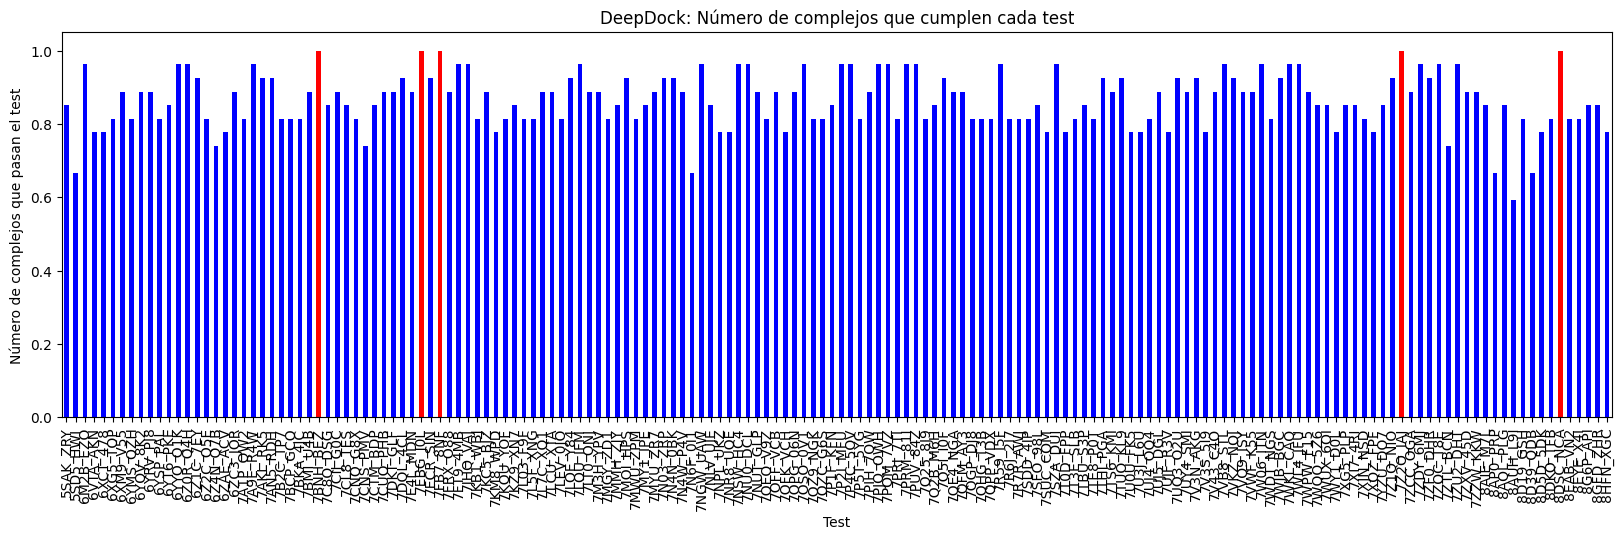

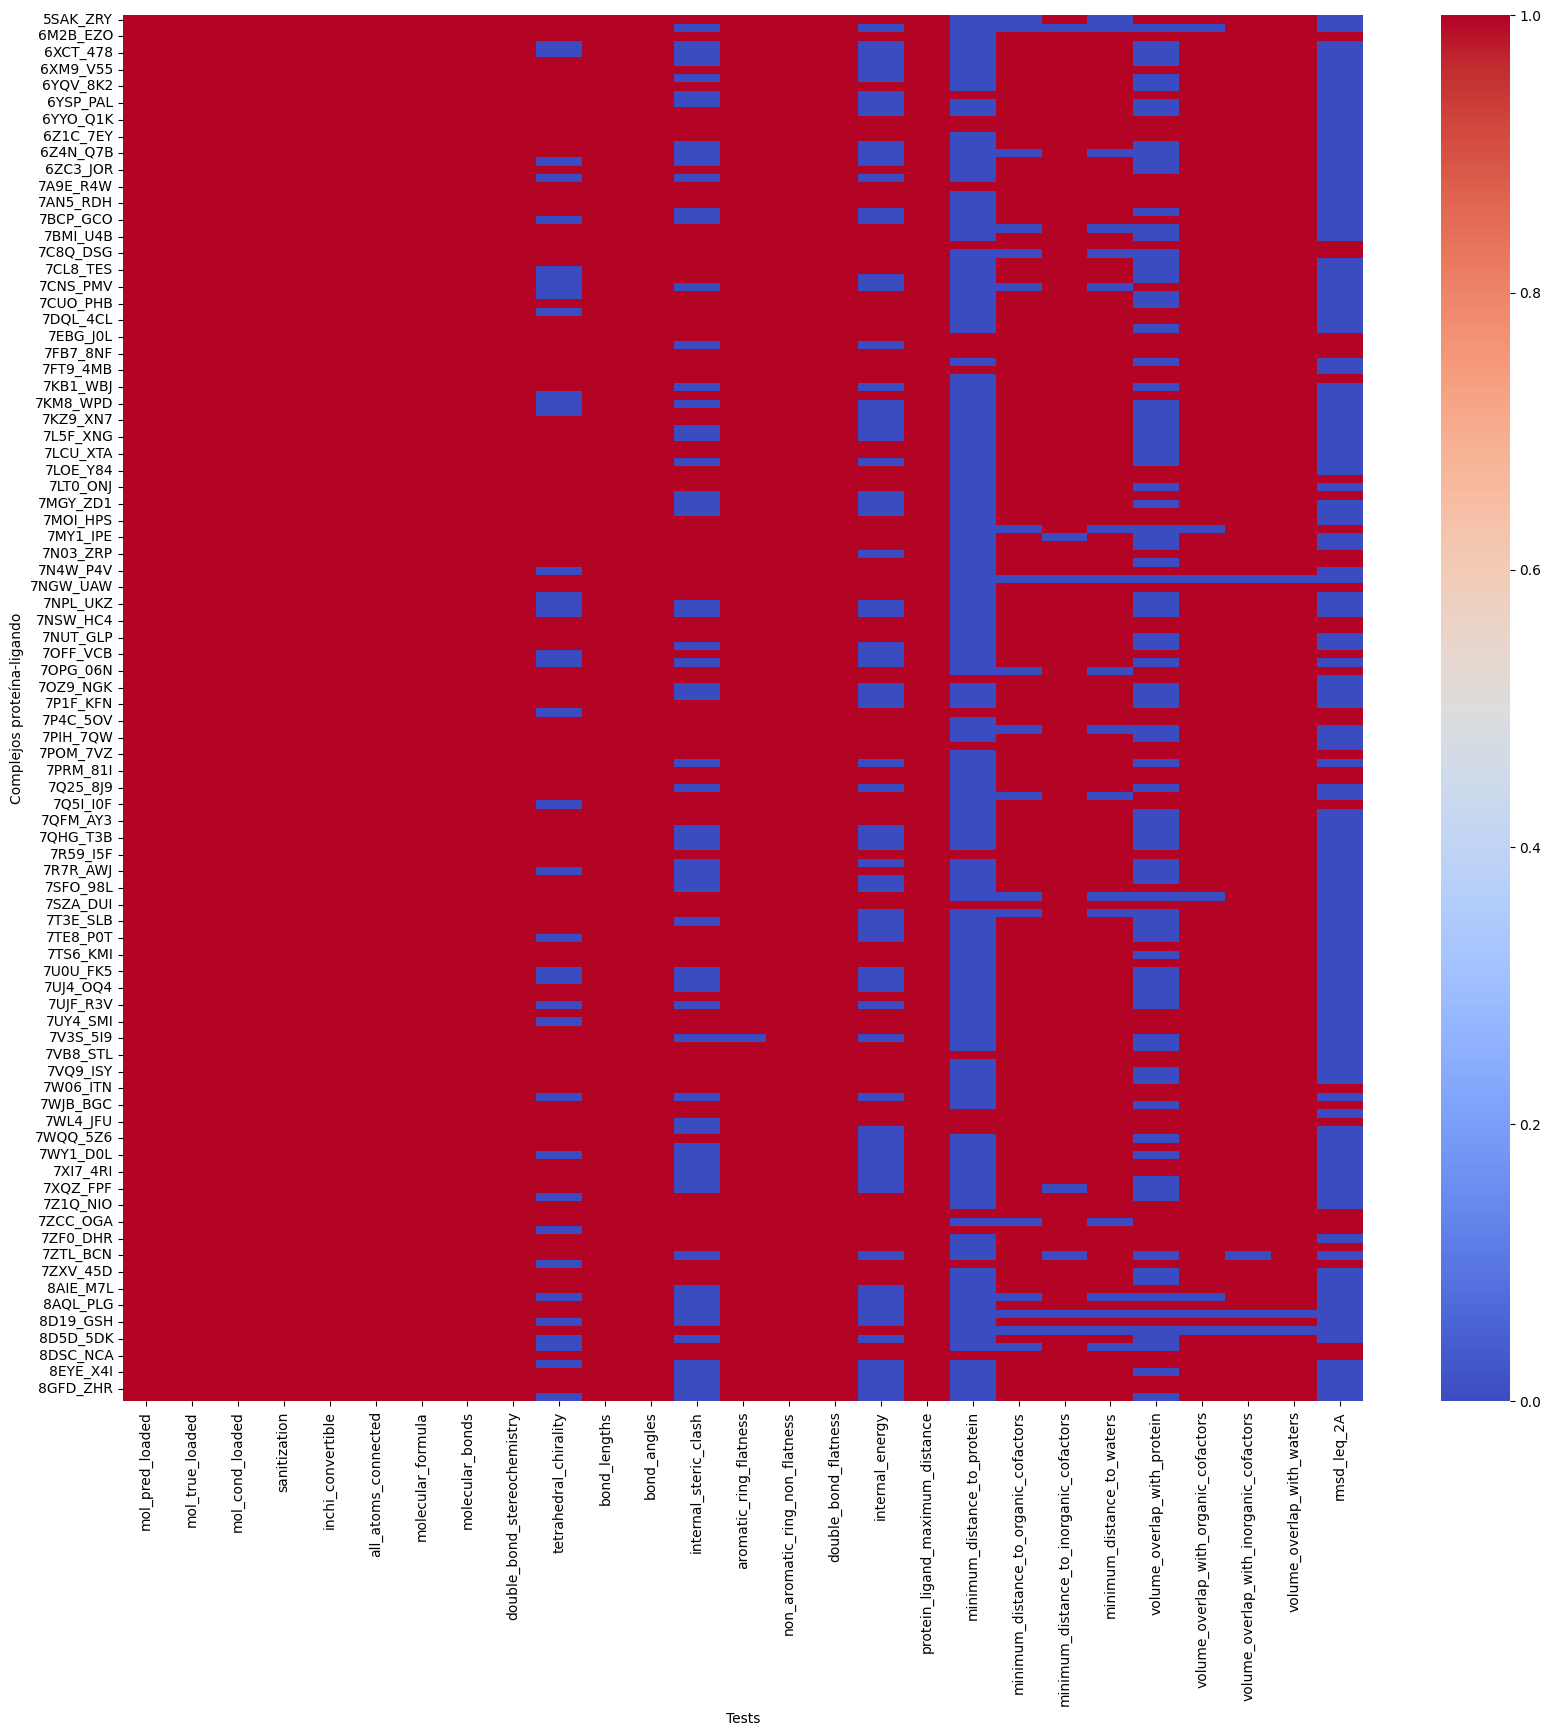

In [52]:
deepdock_pb=filter(load_result("results/results_posebusters_deepdock/resultsBustPBDeepDock.csv"))
plot_test_test_per_complex(deepdock_pb, "DeepDock: Número de complejos que cumplen cada test")
plot_heat_map(deepdock_pb)

#### Start Config

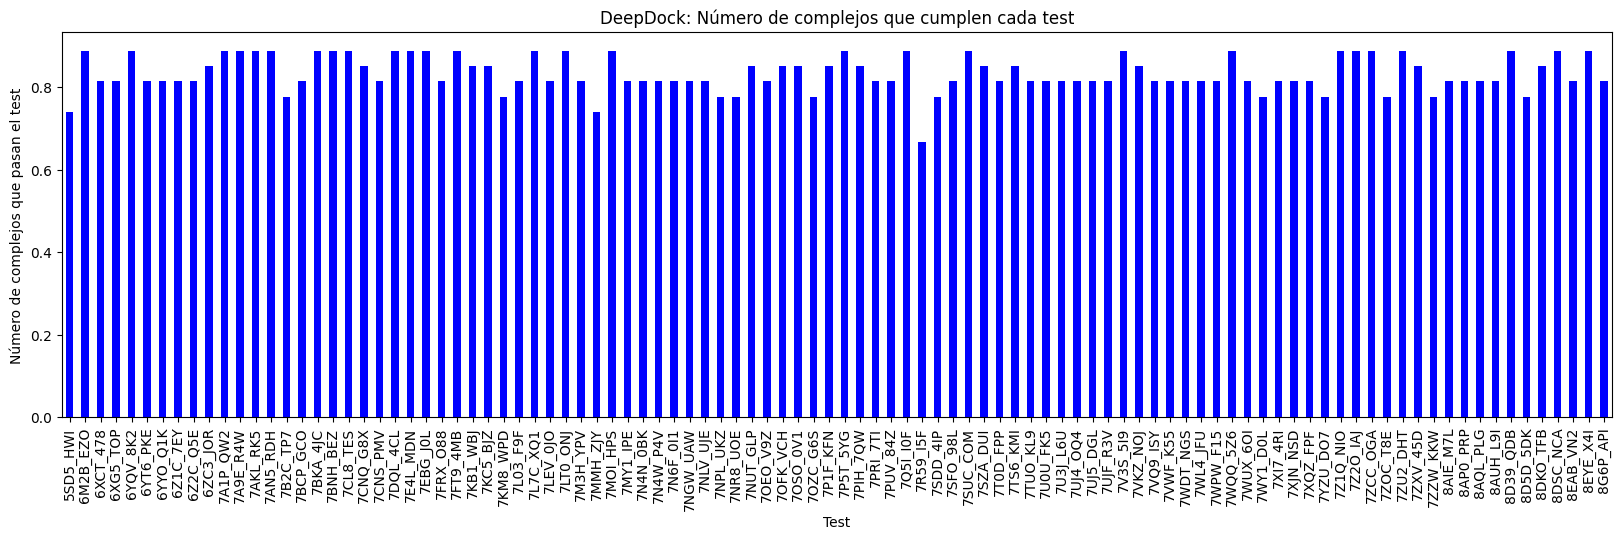

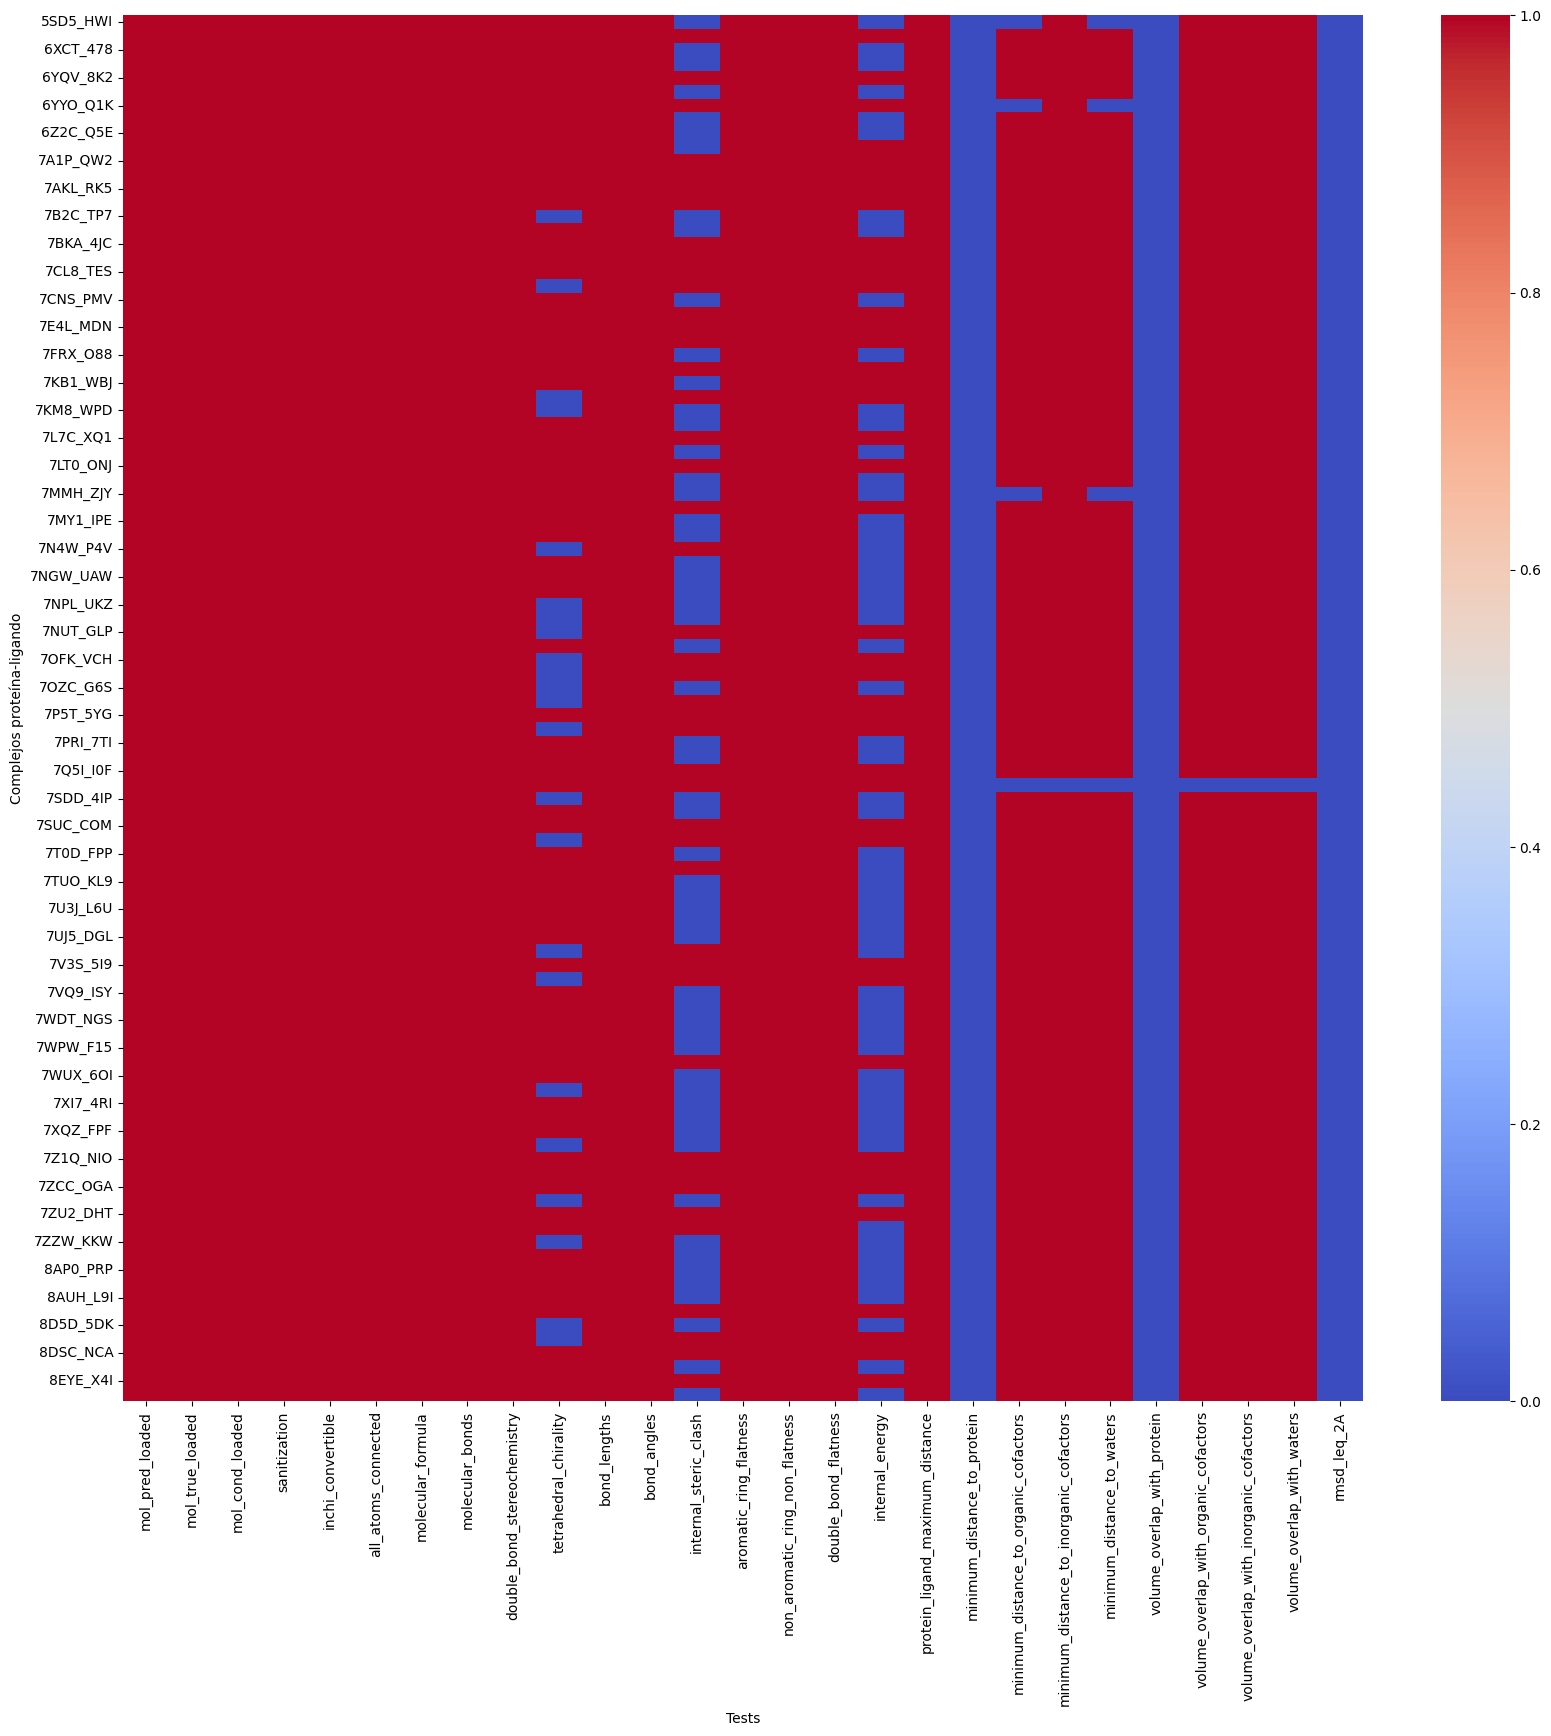

In [55]:
deepdock_pb_start=filter(load_result("results/results_posebusters_start_deepdock/resultsBustPBDeepDockStart.csv"))
plot_test_test_per_complex(deepdock_pb_start, "DeepDock: Número de complejos que cumplen cada test")
plot_heat_map(deepdock_pb_start)

### Resultados Uni Mol
#### Ligand


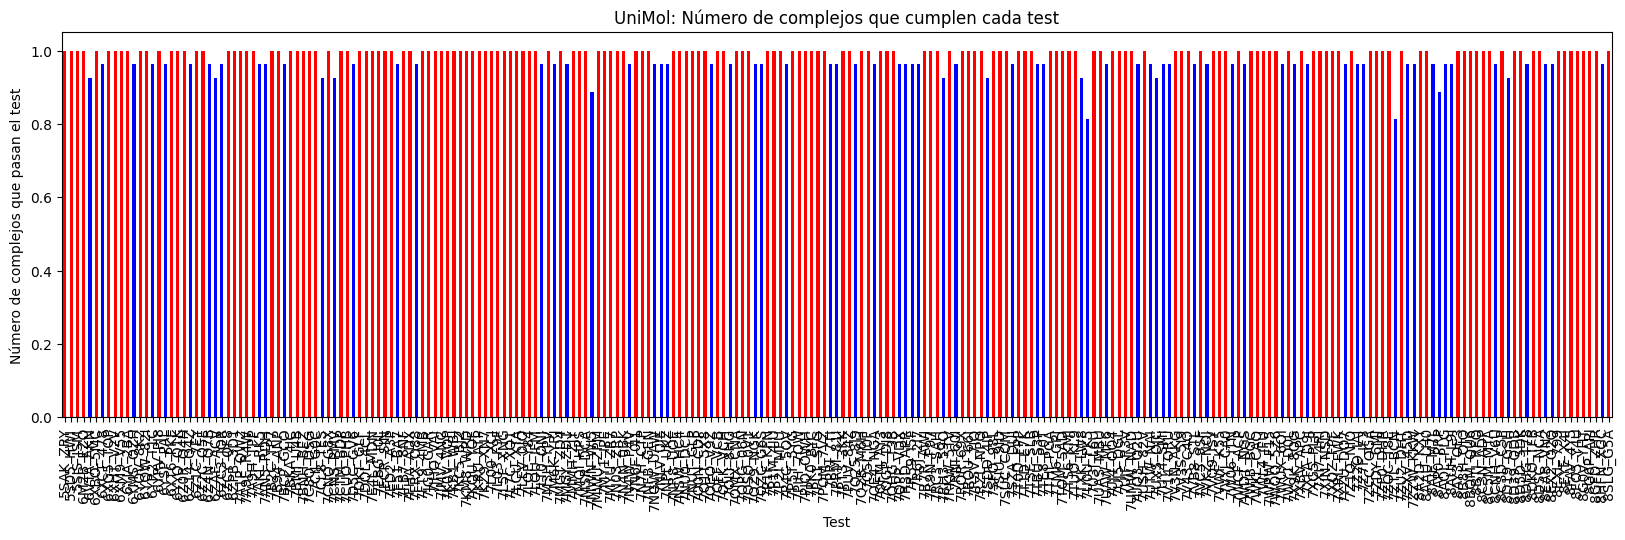

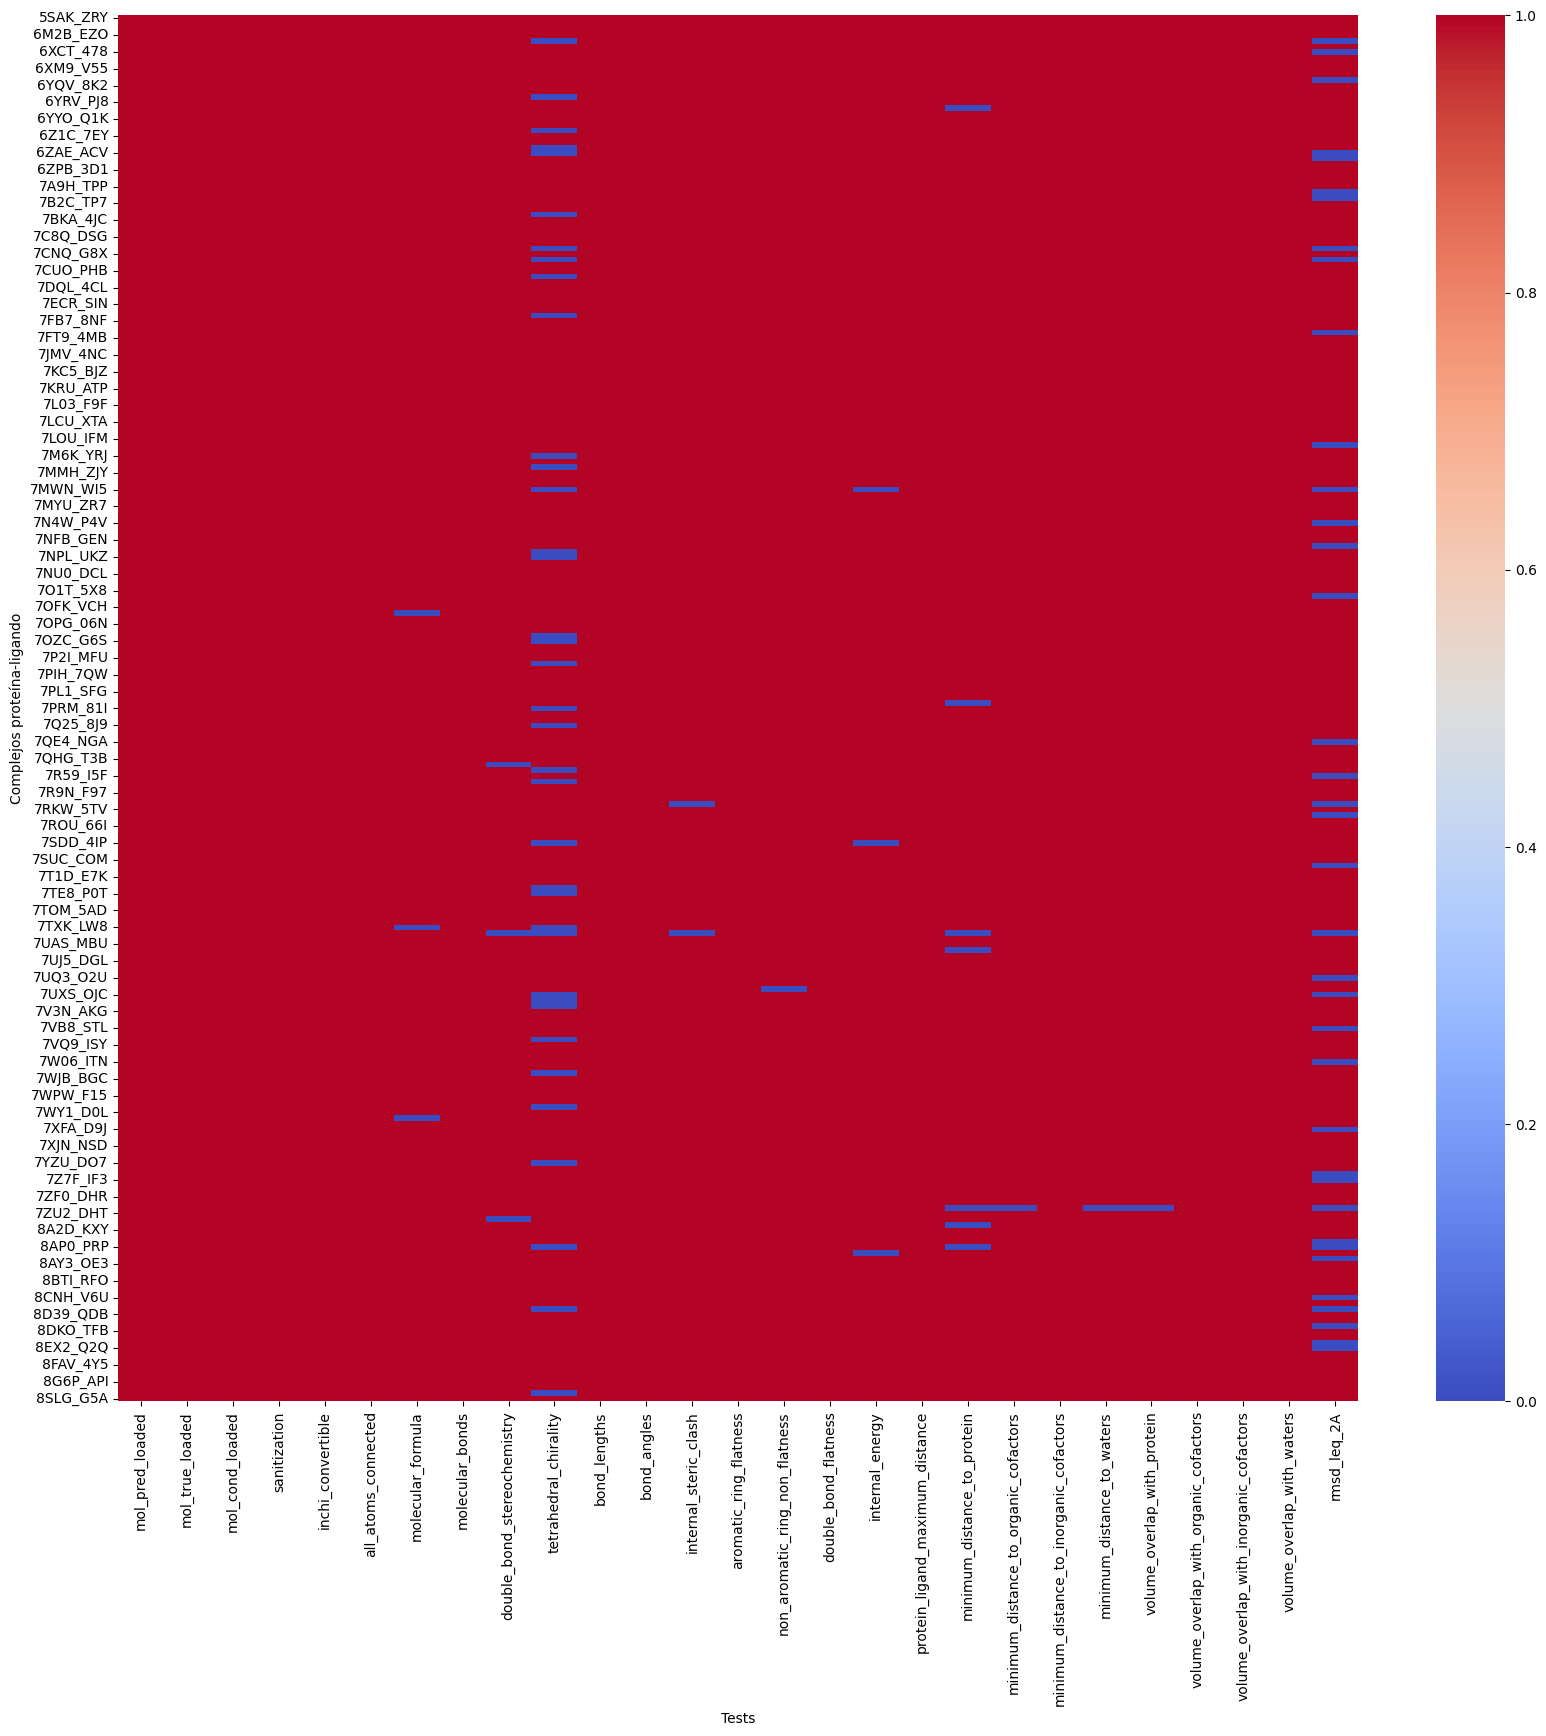

In [56]:
unimol_pb=filter(load_result("results/results_posebusters_unimol/resultsBustUniMol.csv"))
plot_test_test_per_complex(unimol_pb, "UniMol: Número de complejos que cumplen cada test")
plot_heat_map(unimol_pb)

#### Start Config

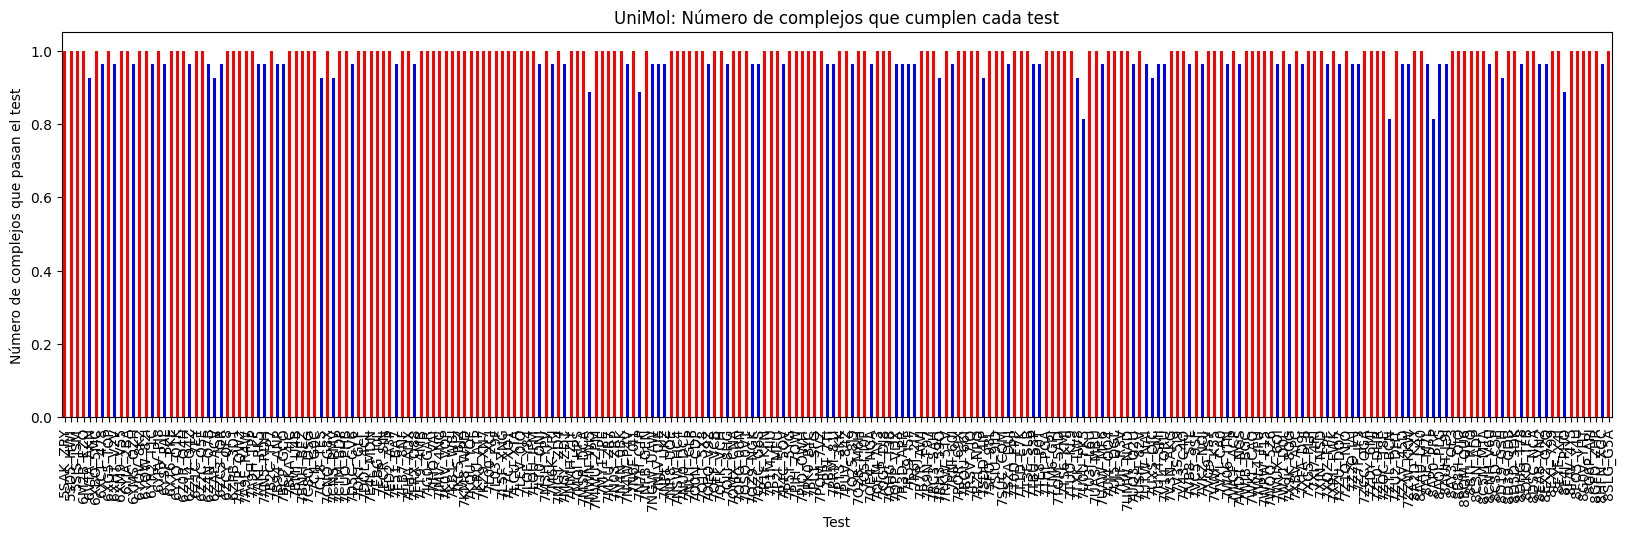

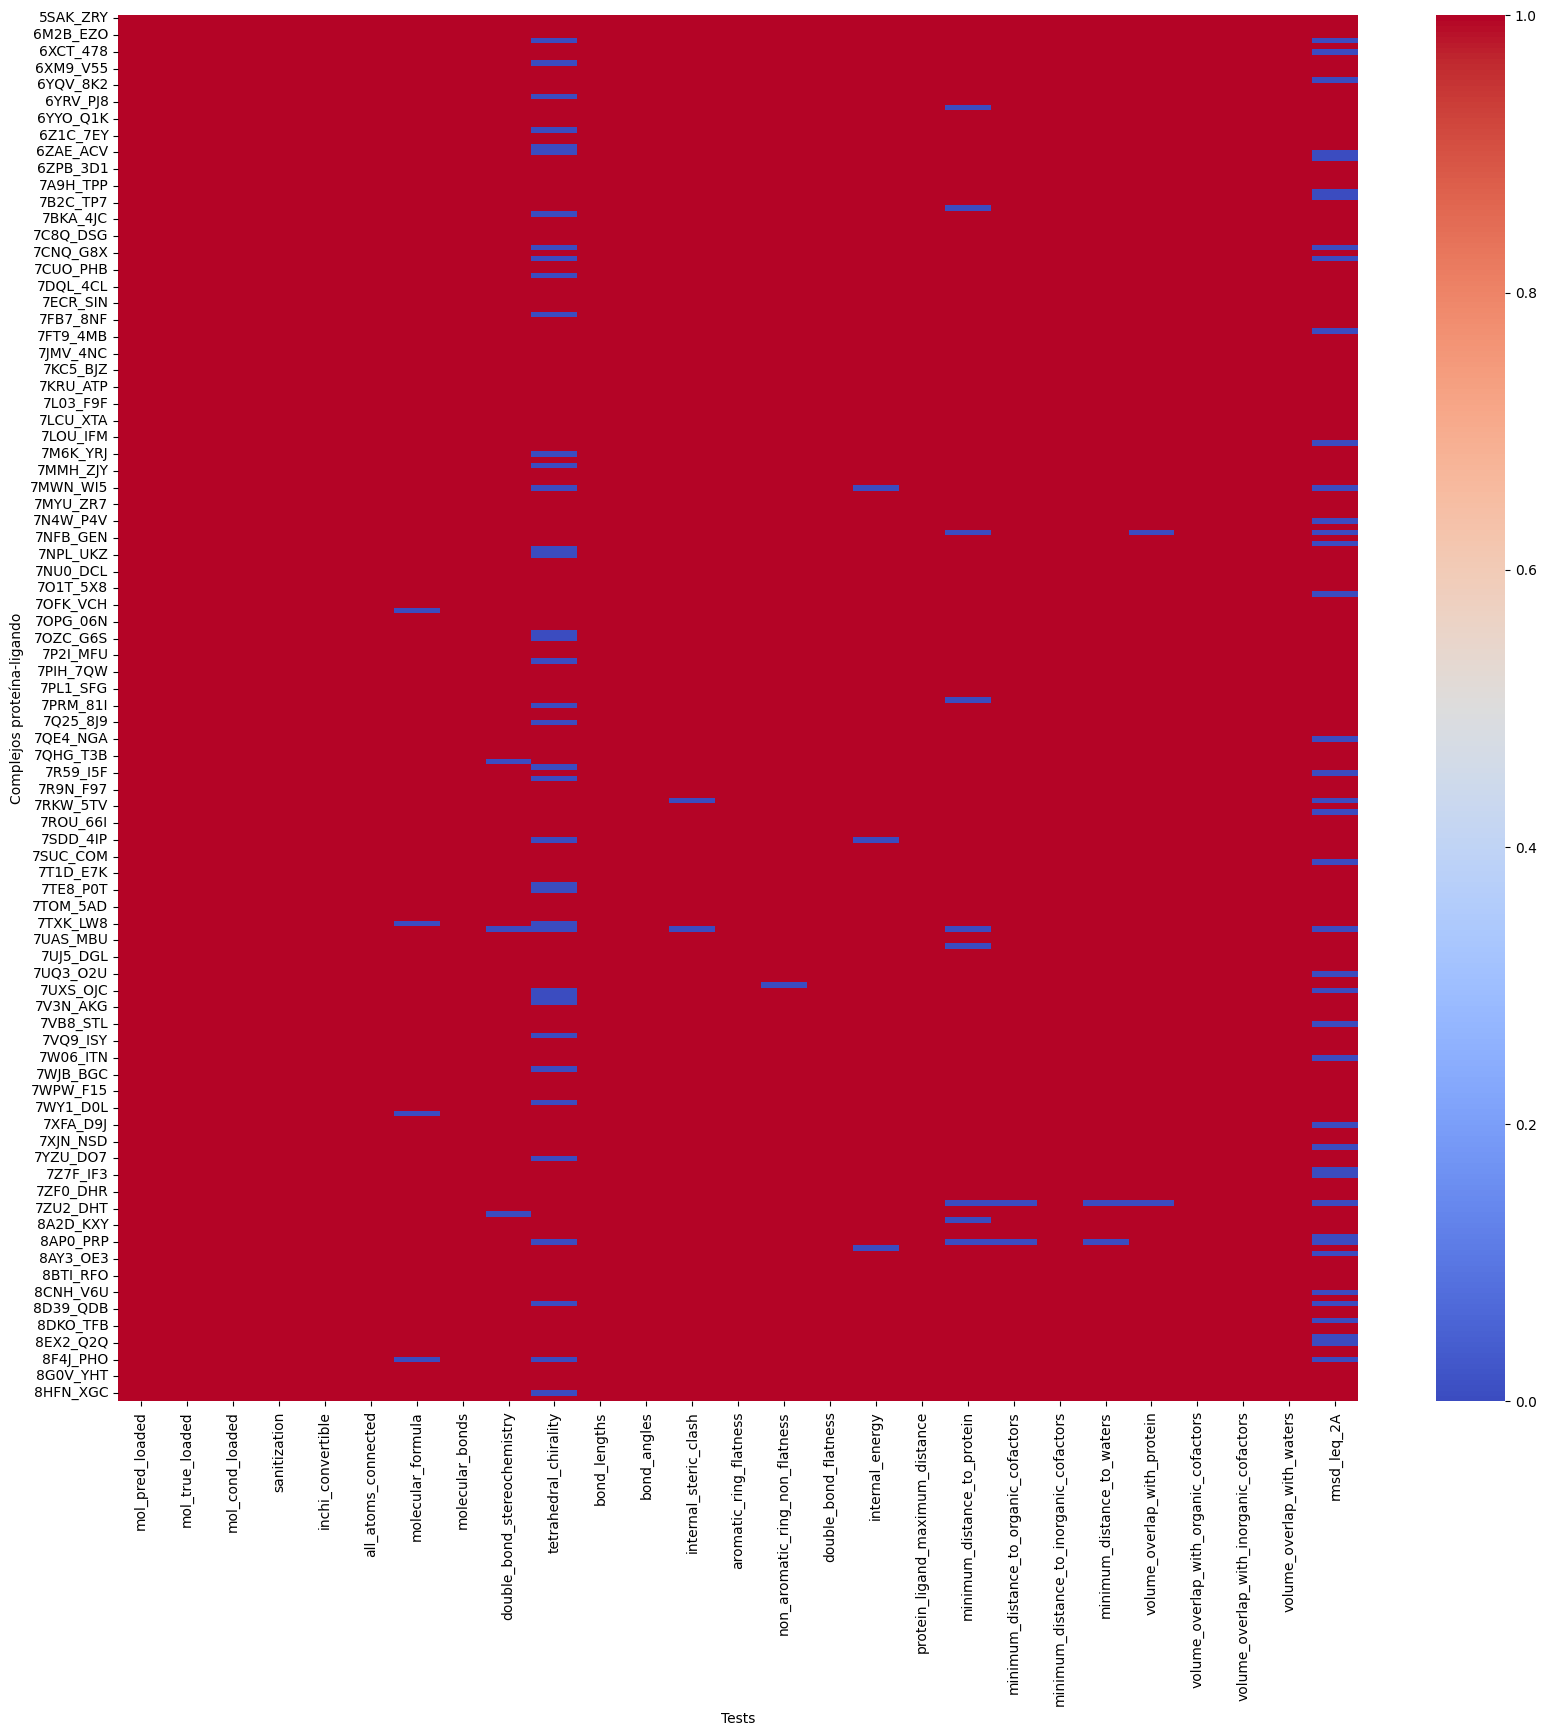

In [58]:
unimol_pb_start=filter(load_result("results/results_posebusters_start_unimol/resultsBust.csv"))
plot_test_test_per_complex(unimol_pb_start, "UniMol: Número de complejos que cumplen cada test")
plot_heat_map(unimol_pb_start)

## Comparar los distintos resultados de PoseBusters Benchmark Set

In [ ]:
pb_lig= {
    "DiffDock": diffdock_pb,
    "DeepDock": deepdock_pb,
    "EquiBind": equibind_pb,
    "Unimol": unimol_pb
}

# Visualización

<b>Resultado para distintas herramientas para 1G9V_RQ3</b>

In [ ]:
visualization(protein_path="data_sets/astex_diverse_set/1Q41_IXM/1Q41_IXM_protein.pdb",
    ligand_list=[
        "results/results_astex_diffdock/1Q41_IXM/complex_0/rank1.sdf",
        "data_sets/astex_diverse_set/1Q41_IXM/1Q41_IXM_ligand.sdf",
        "results/results_astex_equibind/1Q41_IXM/lig_equibind_corrected.sdf",
        "results/results_astex_deepdock/1Q41_IXM/1Q41_IXM_ligand_opt_deepdock.sdf",
        "results/results_astex_unimol/1Q41_IXM/1Q41_IXM_unimol.sdf"
    ],
    colors_list=["red", "blue", "green", "black", "yellow"],)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.